In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [10]:
path = "/home/users/jolivier/oak/users/jolivier/repos/hla-assoc/"
outpath = path + "notebooks/output/AIC_analysis/"

# Find phenoteype and haplotype names

In [11]:
phe_list = []
# get names of cancer phe files

cancerphes_file = open(path + "data/cancerphes.txt", "r")
for line in cancerphes_file.readlines():
    phe_list.append(line[:-1])
cancerphes_file.close()

# get names of HC phe files
for i in range(446):
    phe_list.append("HC" + str(i))

In [12]:
# get haplotype names

hap_list = []

hap_file = open(path + "data/all_haps.txt","r")
for line in hap_file.readlines():
    hap_list.append(line[:-1])
hap_file.close()

# Create AIC dataframes from additive and genetic models

## Additive model dataframe

In [13]:
# initialize dataframe
add_df = pd.DataFrame(index = phe_list, columns = hap_list, dtype = float)

In [14]:
for phe in phe_list:
    add_file = open(path + "scripts/output/reg_test/reg_results/" + phe + "_rounded_add.txt","r")
    curr_allele = ""
    for line in add_file.readlines():
        if line[0] == "$":
            #print(line[1:-1])
            curr_allele = line[1:-1]
        if line[:3] == "AIC":
            #print(line[5:-1])
            add_df[curr_allele][phe] = float(line[5:-1])
            #print(add_df[curr_allele][phe])
    add_file.close()


In [73]:
add_df.to_csv(outpath + "AIC_add.csv")


## Genetic model dataframe

In [16]:
# initialize dataframe
gen_df = pd.DataFrame(index = phe_list, columns = hap_list, dtype = float)

In [17]:
for phe in phe_list:
    gen_file = open(path + "scripts/output/reg_test/reg_results/" + phe + "_rounded_gen.txt","r")
    curr_allele = ""
    for line in gen_file.readlines():
        if line[0] == "$":
            #print(line[1:-1])
            curr_allele = line[1:-1]
        if line[:3] == "AIC":
            #print(line[5:-1])
            gen_df[curr_allele][phe] = float(line[5:-1])
            #print(add_df[curr_allele][phe])
    gen_file.close()

In [18]:
gen_df.to_csv(outpath + "AIC_gen.csv")
gen_df;

In [19]:
sub_df = gen_df.subtract(add_df);
sub_df.to_csv(outpath + "AIC_diff.csv")

In [20]:
outpath

'/home/users/jolivier/oak/users/jolivier/repos/hla-assoc/notebooks/output/AIC_analysis/'

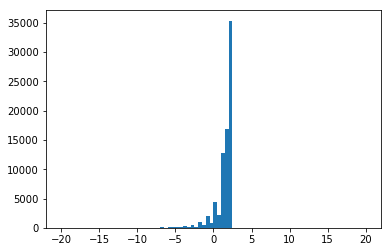

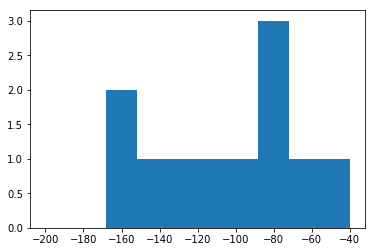

In [21]:
s = sub_df.as_matrix().flatten()
s = s[~np.isnan(s)]

low = -40
high = -200
plt.hist(s, bins=np.arange(-20,20.5,0.5))
plt.show()
plt.hist(s, range=(high,low))
plt.show()
#print(s.dtype)

# Subset to just found associations

In [22]:
adj_p_df = pd.read_csv(path + "notebooks/output/compare_cutoff_pvals/adj_p_vals.csv", header = 0, index_col = 0)

In [38]:
# only keep rows and columns in adj_p_df
# (only looking at alleles and phenotypes that pass our frequency cutoffs)
add_df = add_df.loc[adj_p_df.index.values,adj_p_df.columns.values]
gen_df = gen_df.loc[adj_p_df.index.values,adj_p_df.columns.values]

In [39]:
thresh = 0.05

for allele in add_df.columns.values:
    for phe in add_df.index.values:
        if adj_p_df[allele][phe] > 0.05:
            add_df[allele][phe] = np.nan
            gen_df[allele][phe] = np.nan
        

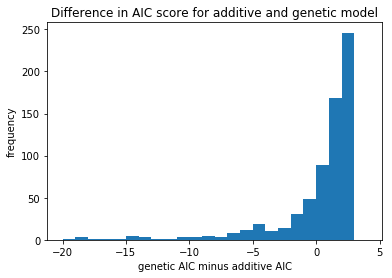

In [190]:
sub_df_2 = gen_df.subtract(add_df)
s2 = sub_df_2.as_matrix().flatten()
s2 = s2[~np.isnan(s2)]
plt.hist(s2, bins=np.arange(-20,5,1))
#plt.hist(s2)
plt.title("Difference in AIC score for additive and genetic model")
plt.ylabel("frequency")
plt.xlabel("genetic AIC minus additive AIC")
plt.savefig(outpath + "AIC_difference_hist.png")
plt.show()

## Analysis

The lower the AIC score, the less information lost for the given model. This means that a negative AIC score indicates that the additive model had a higher AIC score, so the genetic model resulted in less information loss. Therefore these are the models where we expect non-additive effects

# Number below AIC threshold (Evidence for nonadditive effects)

In [189]:
AIC_thresh = -1
print(len(s2[s2< AIC_thresh]))
print(len(s2[s2< -20]))

152
27


# Get log(OR) and std from R output

## Find values for genetic model

In [86]:
# initialize dataframes
gen_logOR_1 = pd.DataFrame(index = phe_list, columns = hap_list, dtype = float)
gen_logOR_2 = pd.DataFrame(index = phe_list, columns = hap_list, dtype = float)
gen_std_1 = pd.DataFrame(index = phe_list, columns = hap_list, dtype = float)
gen_std_2 = pd.DataFrame(index = phe_list, columns = hap_list, dtype = float)


In [92]:
for phe in phe_list:
    gen_file = open(path + "scripts/output/reg_test/reg_results/" + phe + "_rounded_gen.txt","r")
    curr_allele = ""
    for line in gen_file.readlines():
        if line[0] == "$":
            #print(line[1:-1])
            curr_allele = line[1:-1]
        else:
            words = line.split()
            if len(words) > 1:
                if words[0] == "as.factor(gcounts)1":
                    #print(line[5:-1])
                    gen_logOR_1[curr_allele][phe] = float(words[1])
                    gen_std_1[curr_allele][phe] = float(words[2])
                    #print(add_df[curr_allele][phe])
                elif words[0] == "as.factor(gcounts)2":
                    gen_logOR_2[curr_allele][phe] = float(words[1])
                    gen_std_2[curr_allele][phe] = float(words[2])
    gen_file.close()

In [101]:
gen_logOR_1.to_csv(outpath + "gen_logOR_1")
gen_logOR_2.to_csv(outpath + "gen_logOR_2")
gen_std_1.to_csv(outpath + "gen_std_1")
gen_std_2.to_csv(outpath + "gen_std_2")


## Find values for additive model

In [94]:
# initialize dataframes
add_logOR = pd.DataFrame(index = phe_list, columns = hap_list, dtype = float)
add_std = pd.DataFrame(index = phe_list, columns = hap_list, dtype = float)


In [99]:
for phe in phe_list:
    add_file = open(path + "scripts/output/reg_test/reg_results/" + phe + "_rounded_add.txt","r")
    curr_allele = ""
    for line in add_file.readlines():
        if line[0] == "$":
            #print(line[1:-1])
            curr_allele = line[1:-1]
        else:
            words = line.split()
            #print("phe: {} curr_allele: {}".format(phe, curr_allele))
            if len(words) > 1:
                if words[0] == "as.numeric(gcounts)":
                    if words[1] != "NA":
                        #print(line[5:-1])
                        add_logOR[curr_allele][phe] = float(words[1])
                        add_std[curr_allele][phe] = float(words[2])
                        #print(add_df[curr_allele][phe])

    add_file.close()

In [103]:
add_logOR.to_csv(outpath + "add_logOR")
add_std.to_csv(outpath + "add_std")


In [171]:
phe_dict = {}

HC_file = open(path + "data/highconfidenceqc_map.csv", "r")
HC_file.readline()
for line in HC_file.readlines():
    line = line.split(",")
    phe_dict[line[0]] = line[1][:-1]
HC_file.close()
phe_dict

cancer_file = open(path + "data/cancermap.csv", "r")
cancer_file.readline()
for line in cancer_file.readlines():
    line = line.split(",")
    phe_dict[line[0][6:]] = line[1][:-1]
cancer_file.close()
phe_dict


allele_dict = {}
allele_file = open(path + "data/ukb_to_asterisk_names.csv", "r")
allele_file.readline()
for line in allele_file.readlines():
    line = line.split(",")
    allele_dict[line[0]] = line[1][:-1]
allele_file.close()


In [183]:
def compare_OR_plot(phe, hap, gen_logOR_1, gen_logOR_2, gen_std_1, gen_std_2, add_logOR, add_std, sub_df, save_path):
    y = ["genetic", "additive"]
    yn = [1,2]
    plt.errorbar(add_logOR[hap][phe], yn[1], marker = "o", xerr = add_std[hap][phe]*1.959, color = "red", label = "Additive")
    plt.errorbar(gen_logOR_1[hap][phe], yn[0], marker = "o", xerr = gen_std_1[hap][phe]*1.959, color = "blue", label = "Dosage 1")
    plt.errorbar(gen_logOR_2[hap][phe], yn[0], marker = "o", xerr = gen_std_2[hap][phe]*1.959, color = "green", label = "Dosage 2")
    plt.yticks(yn, y)
    plt.ylim([0.5,2.5])
    #plt.xlim([0,1])
    plt.title(phe_dict[phe] + ", " + allele_dict[hap] + "\nAIC difference: " + str(sub_df[hap][phe]))
    plt.legend()
    plt.savefig(save_path + phe + "-" + hap + ".png")
    plt.show()

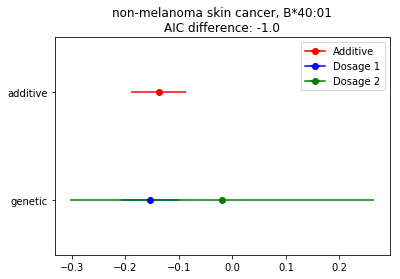

In [177]:
compare_OR_plot("1060","B_4001", gen_logOR_1, gen_logOR_2, gen_std_1, gen_std_2, add_logOR, add_std, sub_df_2)

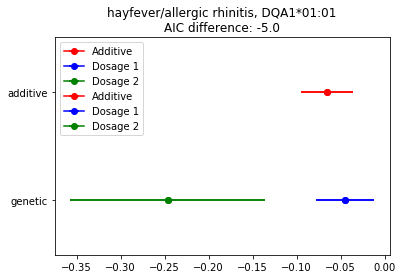

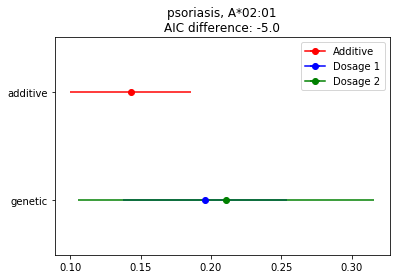

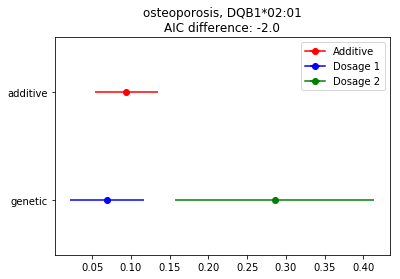

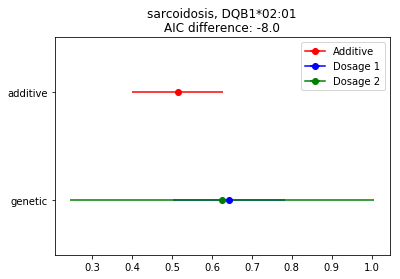

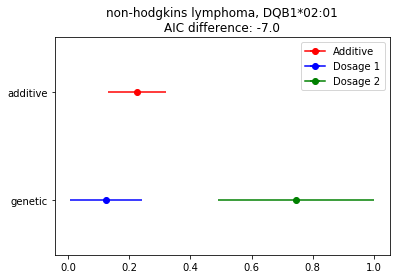

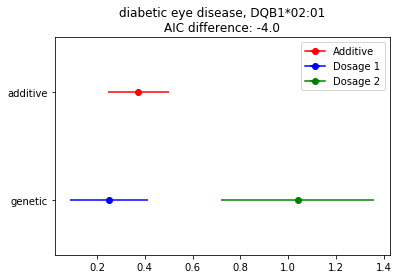

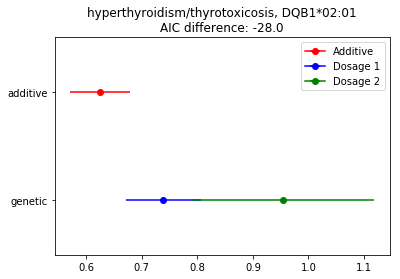

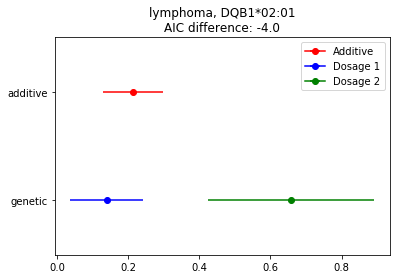

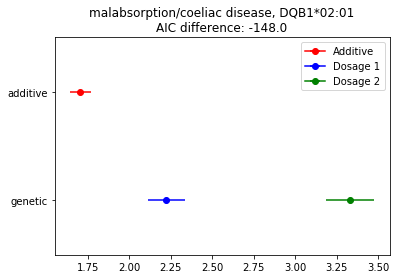

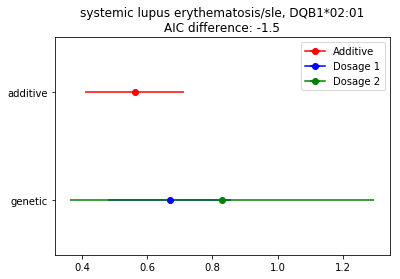

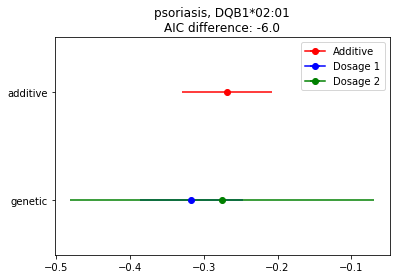

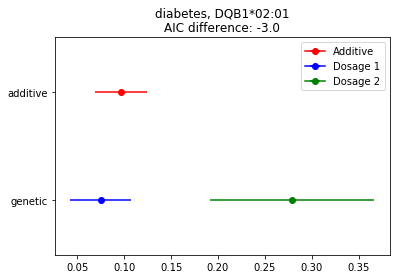

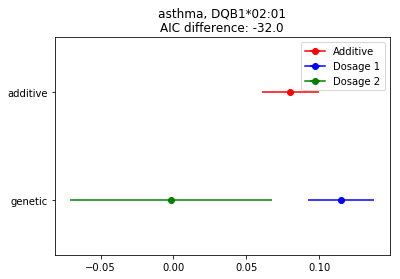

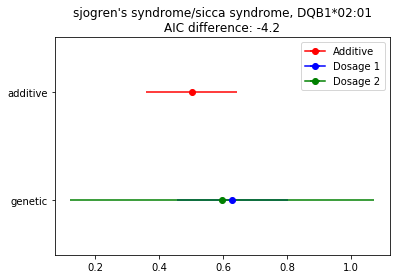

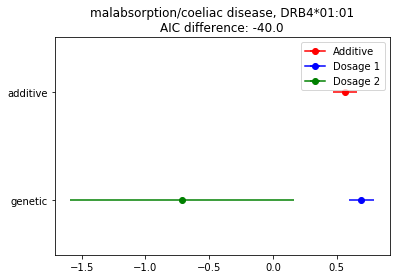

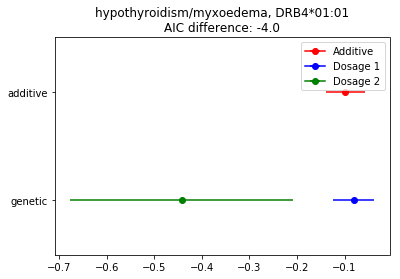

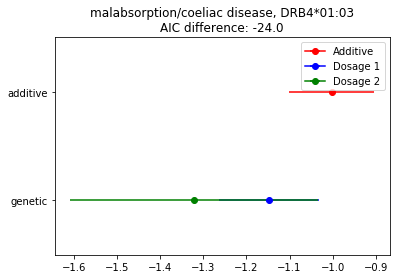

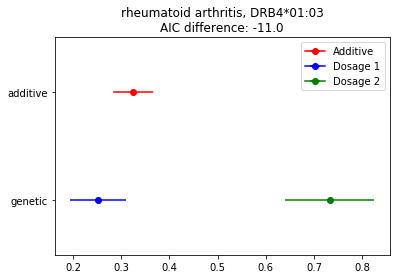

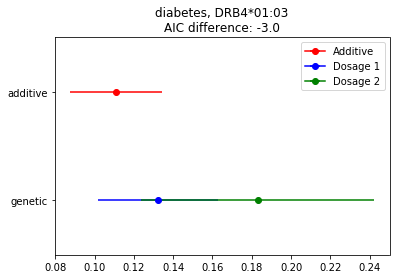

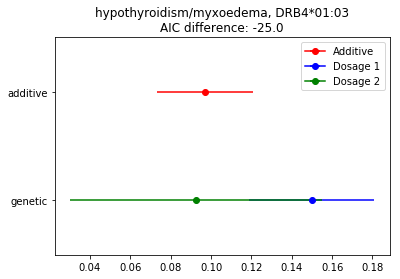

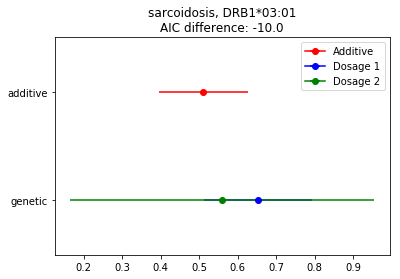

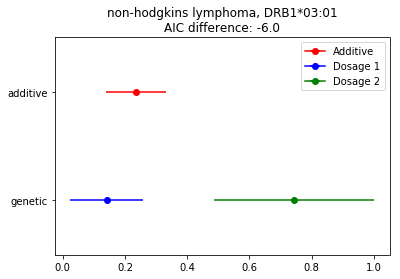

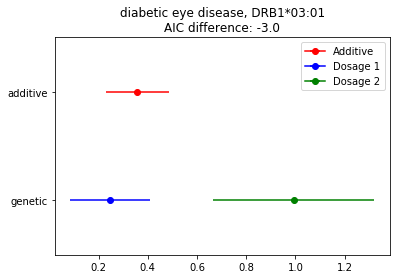

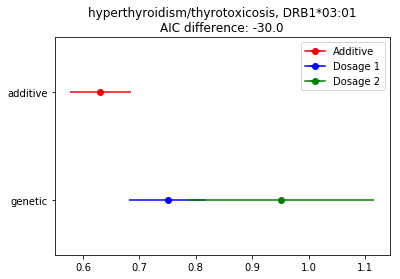

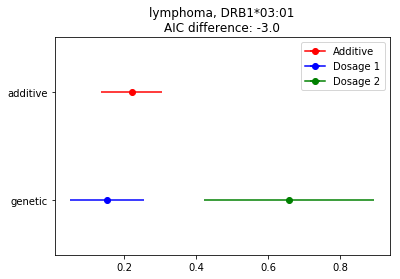

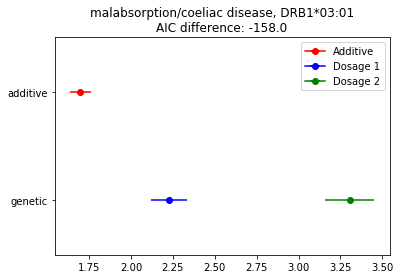

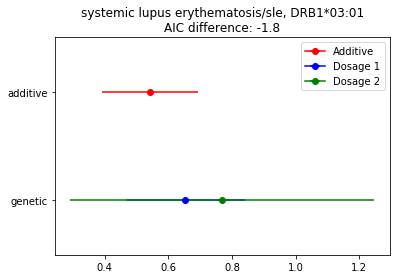

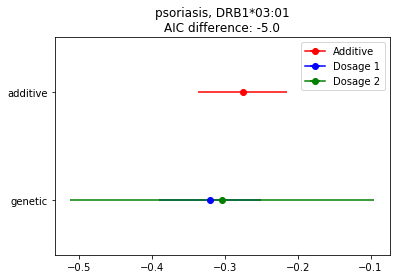

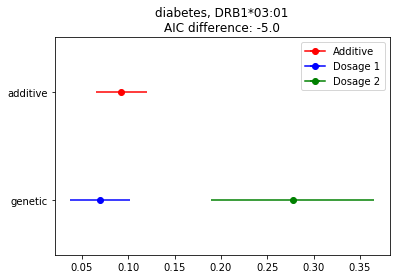

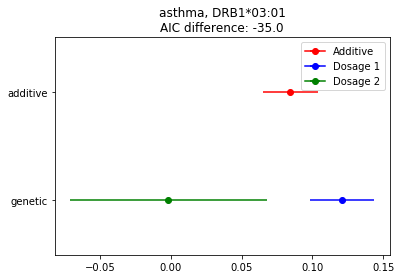

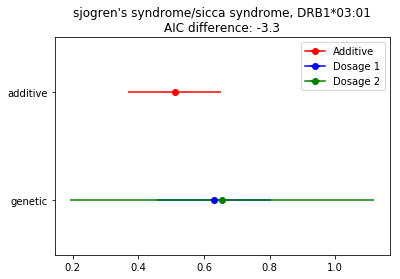

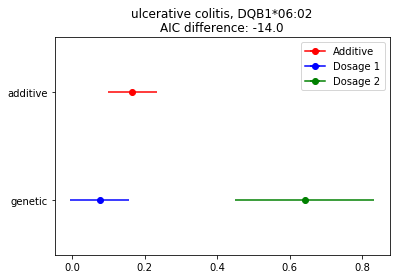

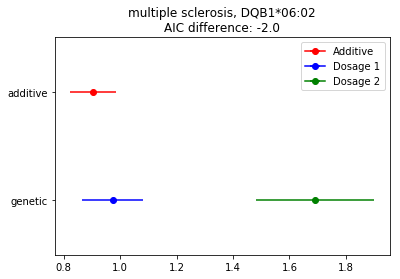

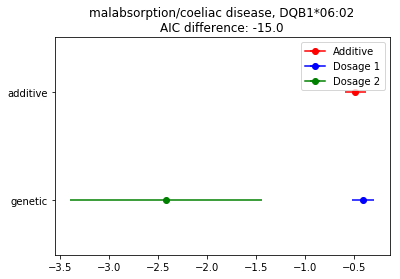

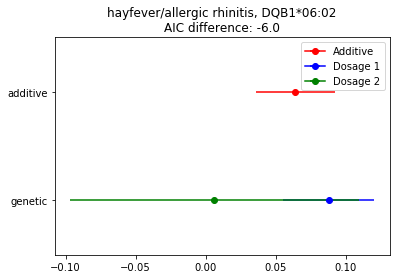

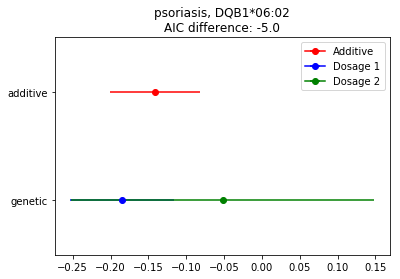

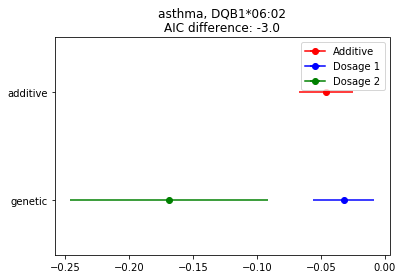

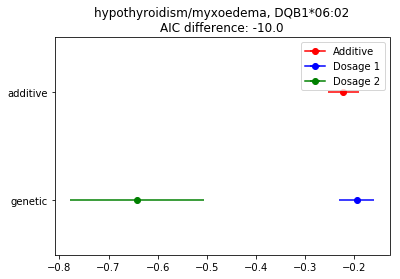

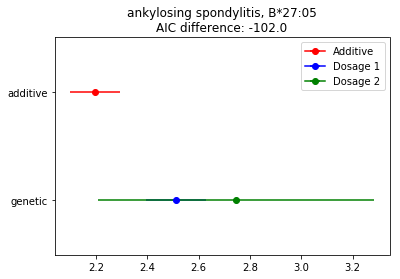

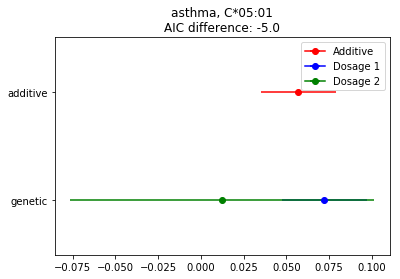

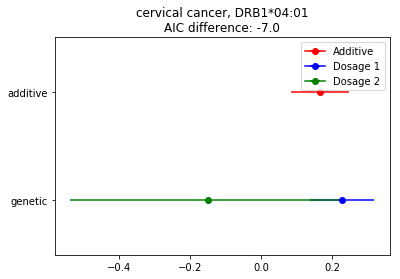

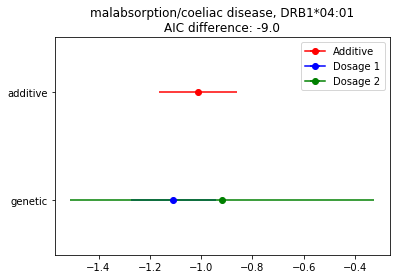

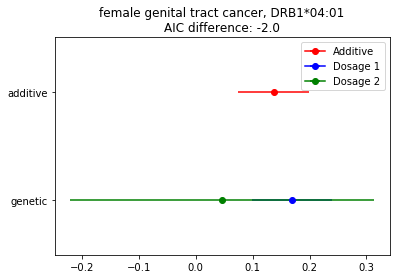

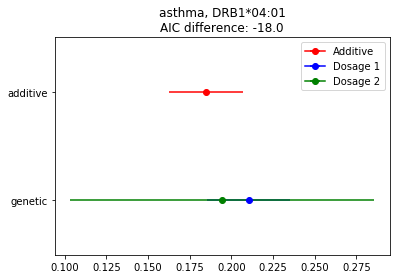

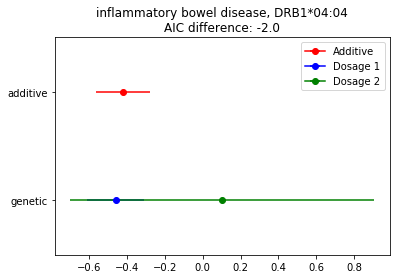

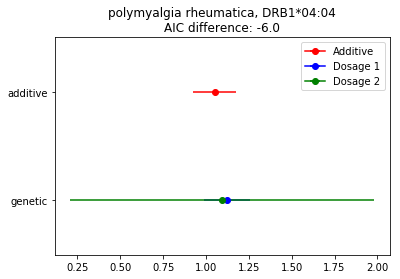

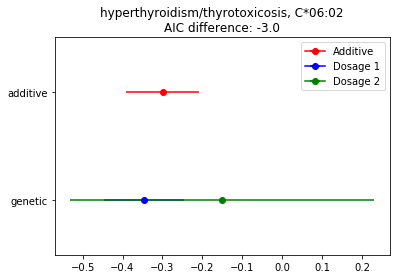

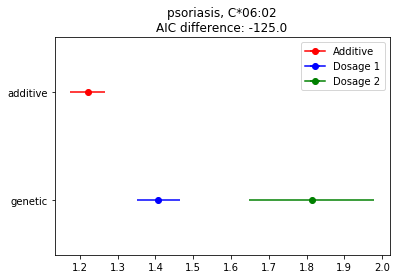

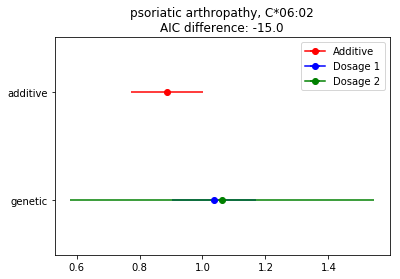

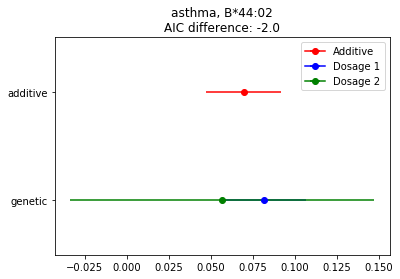

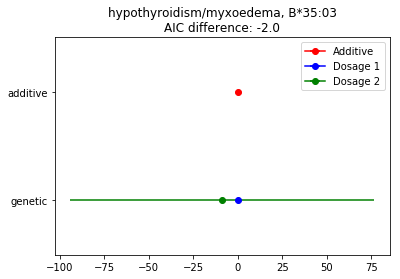

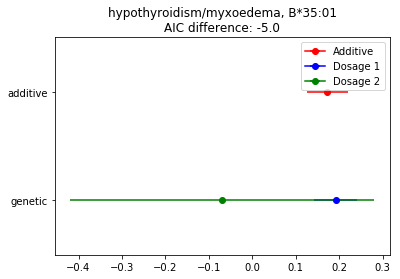

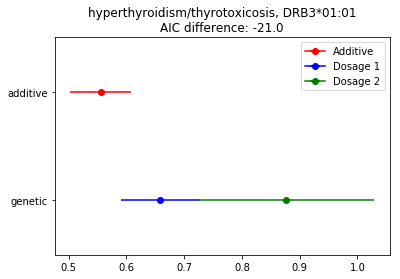

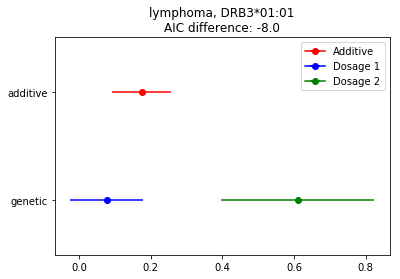

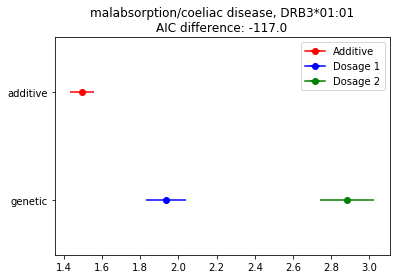

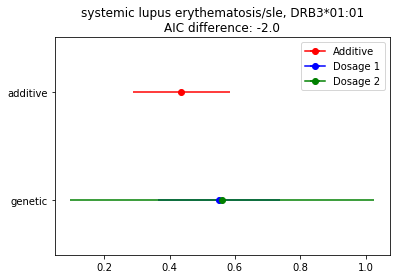

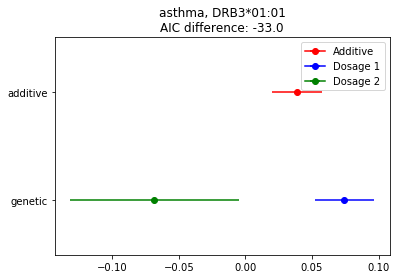

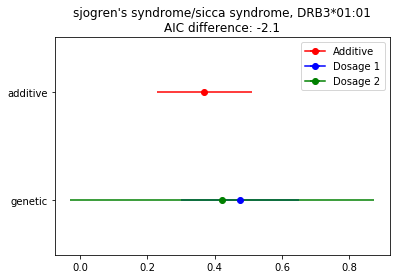

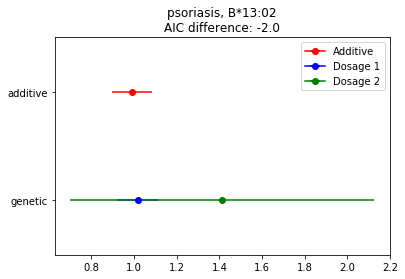

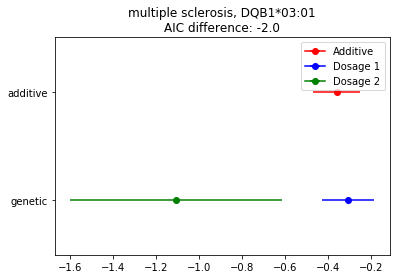

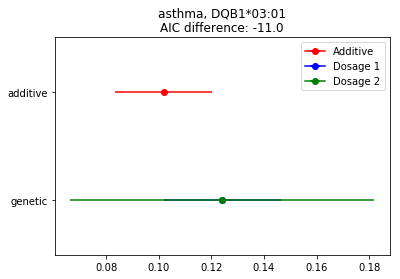

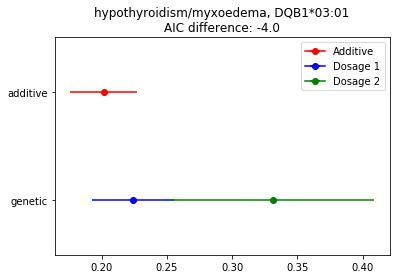

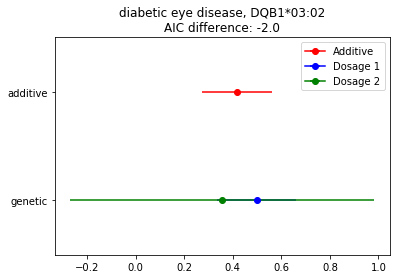

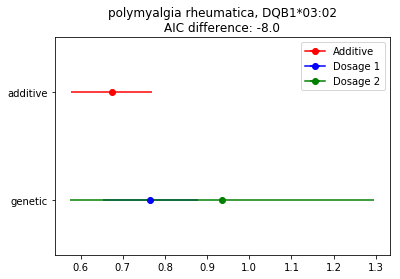

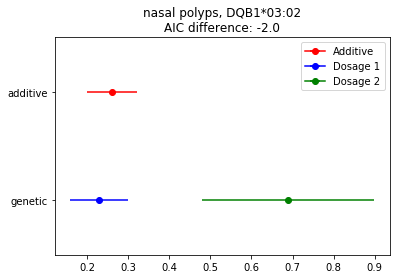

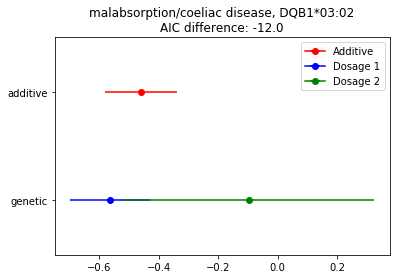

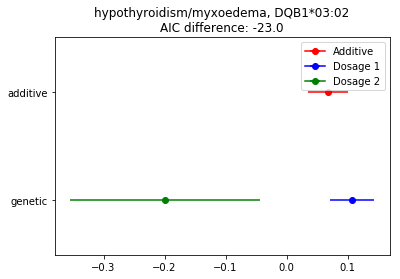

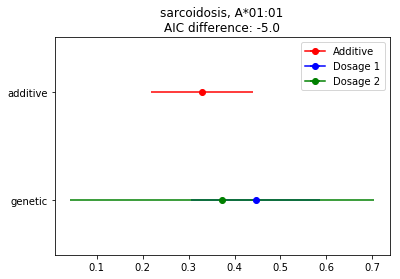

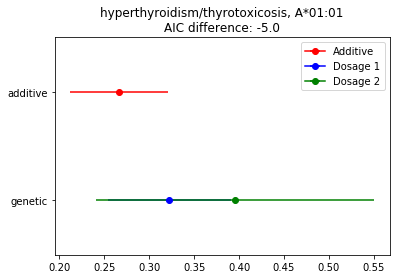

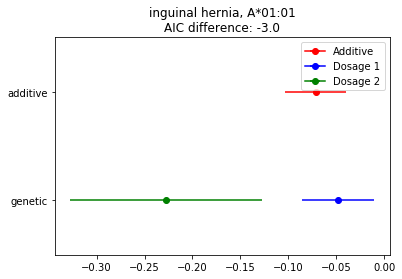

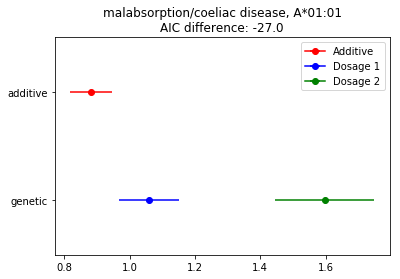

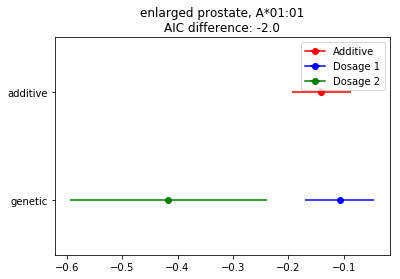

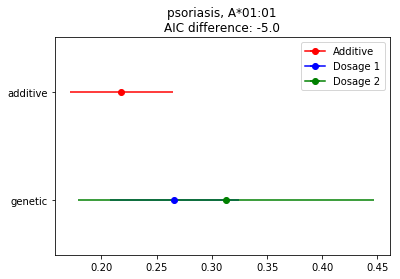

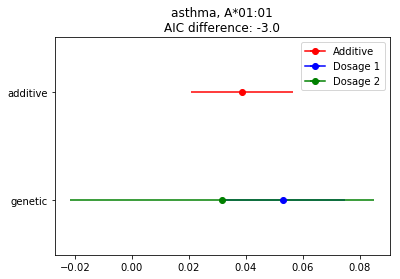

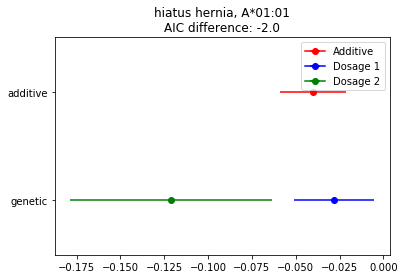

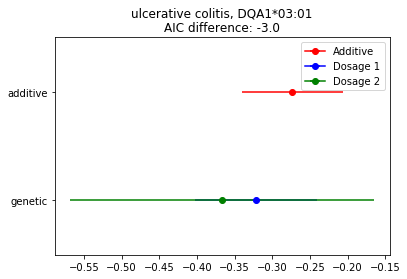

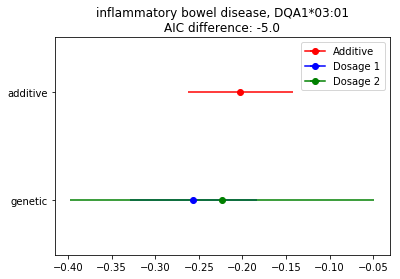

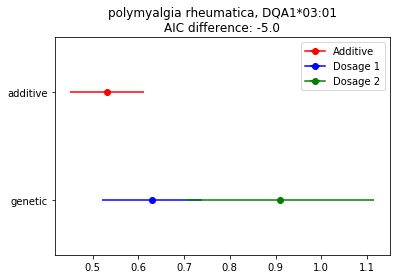

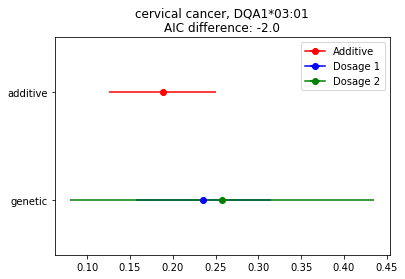

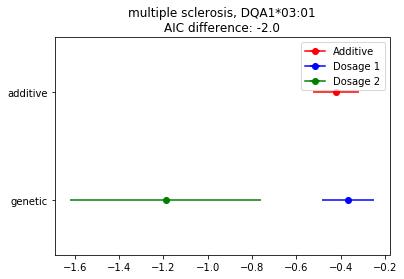

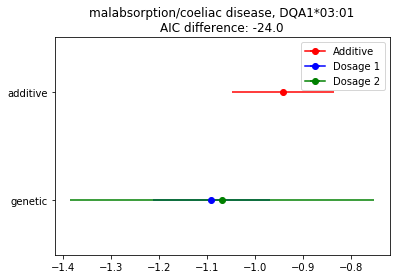

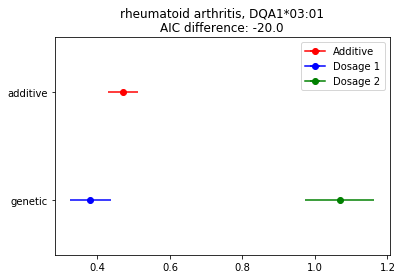

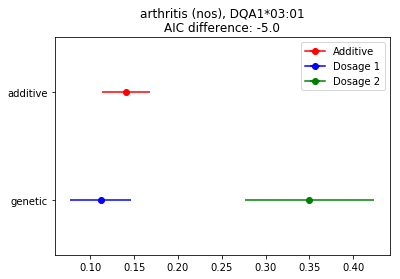

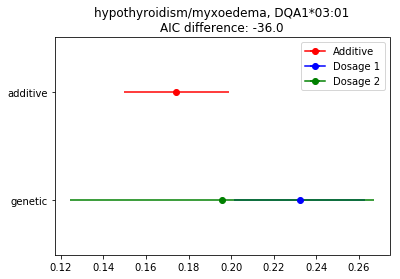

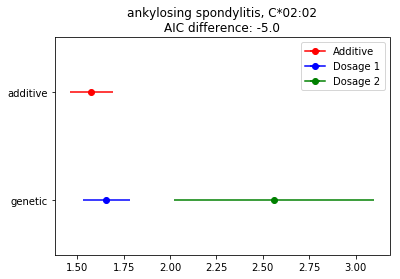

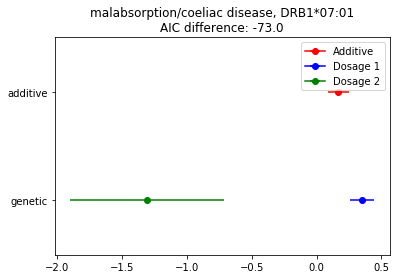

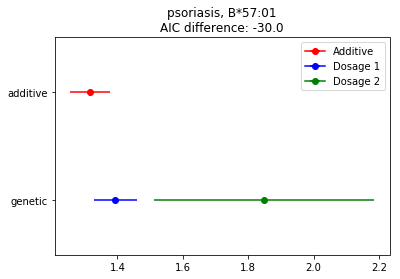

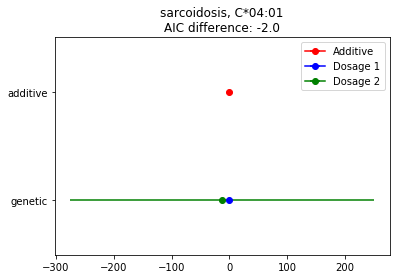

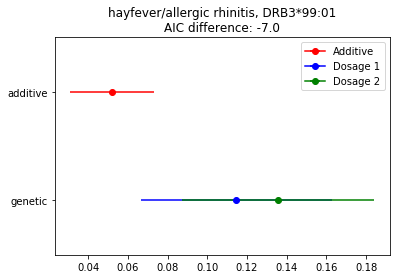

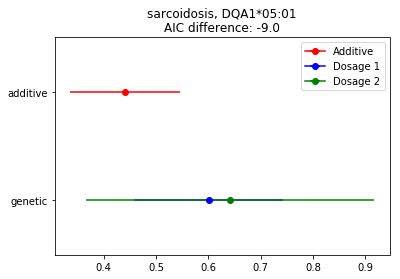

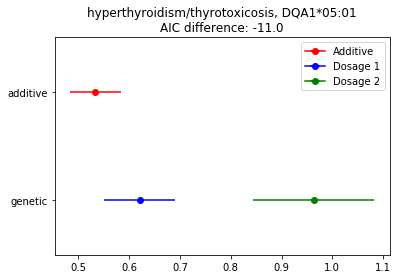

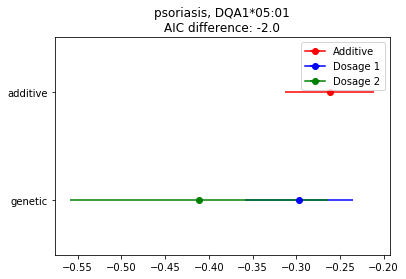

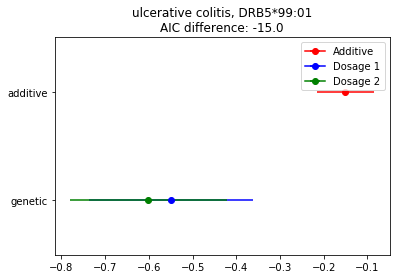

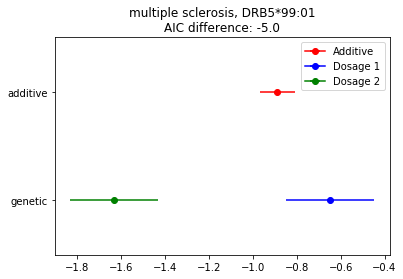

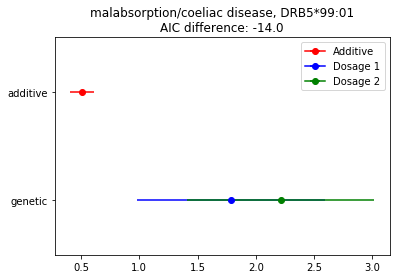

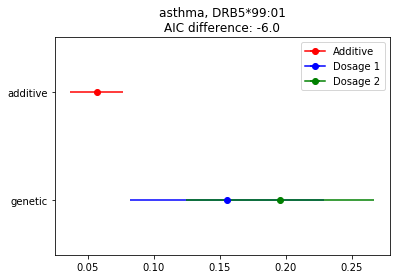

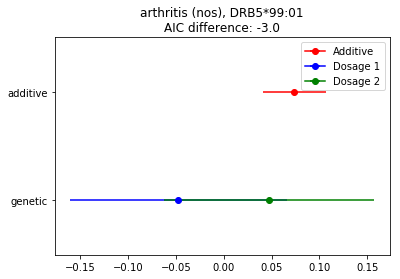

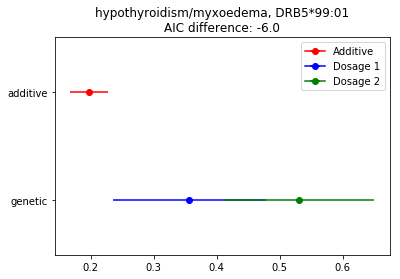

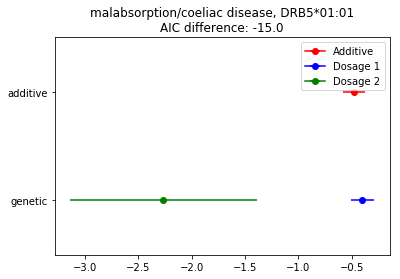

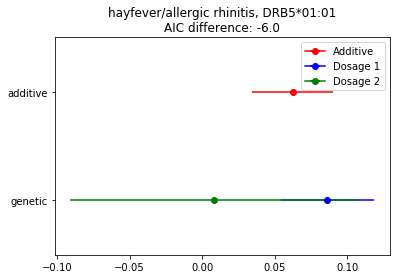

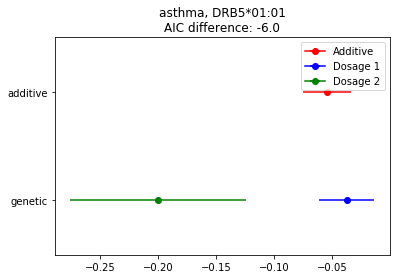

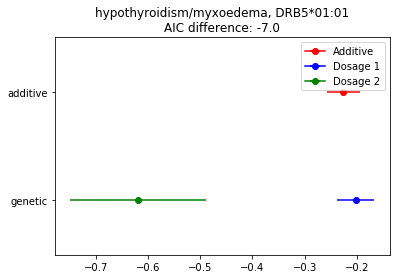

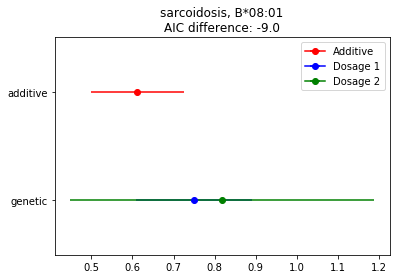

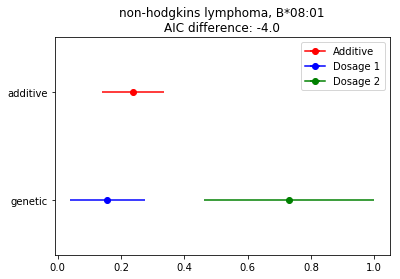

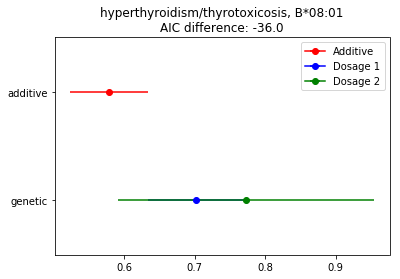

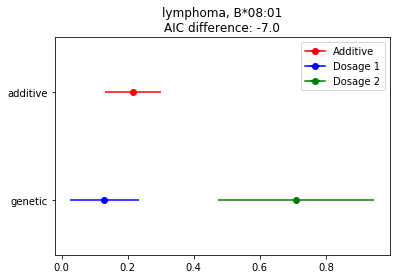

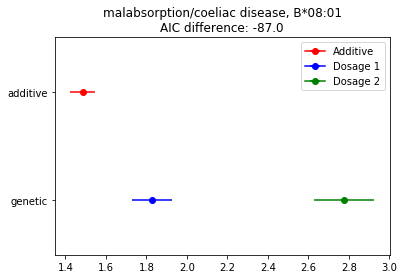

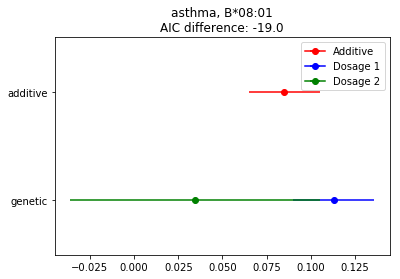

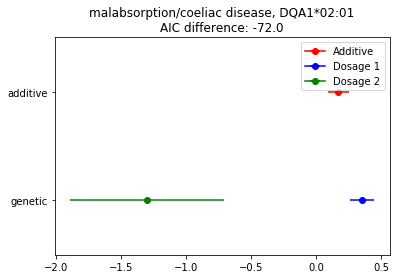

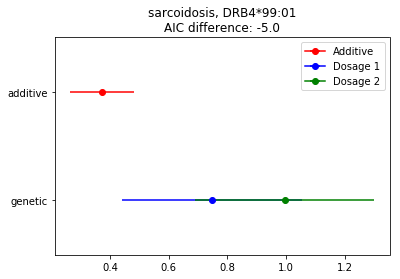

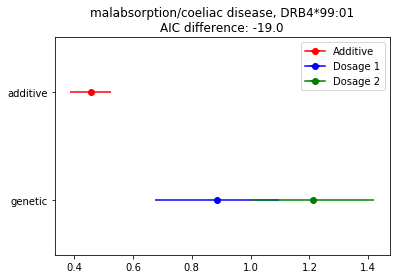

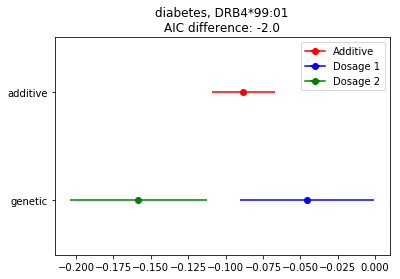

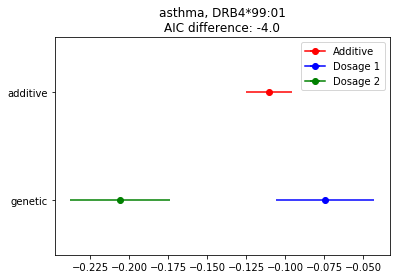

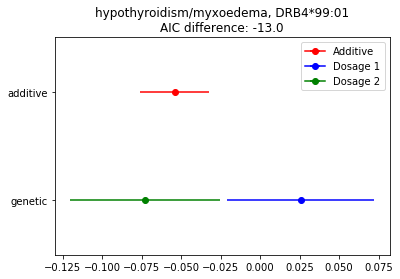

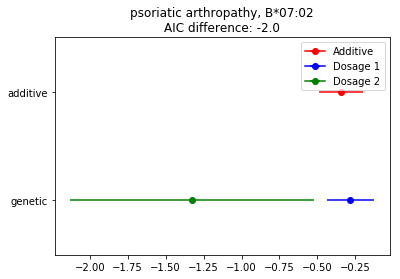

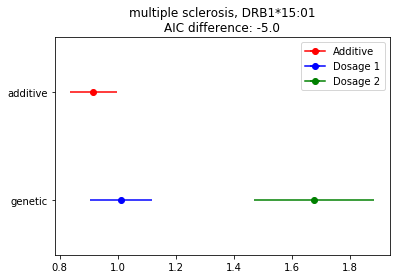

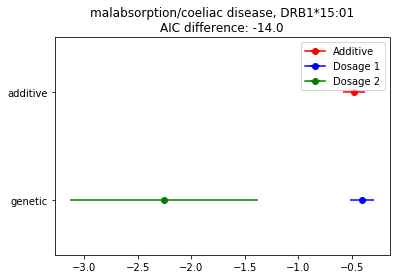

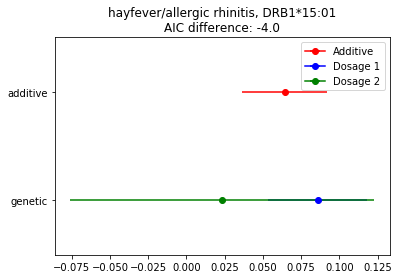

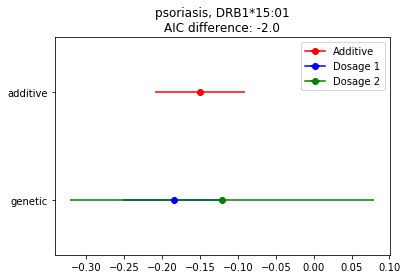

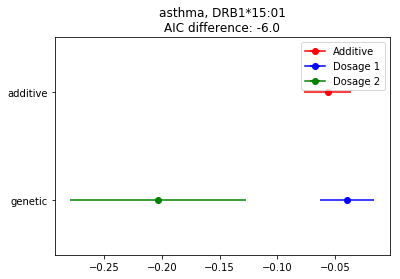

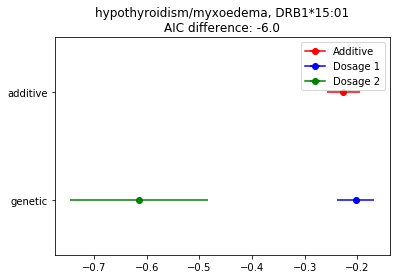

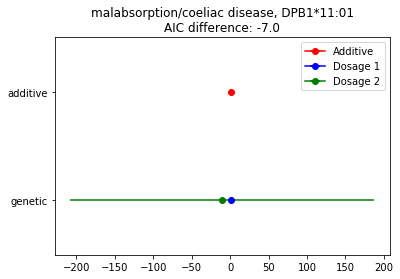

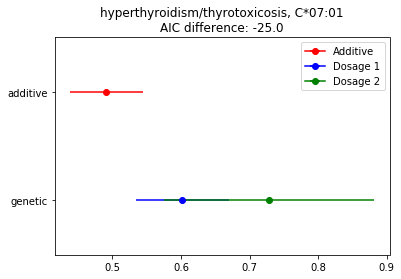

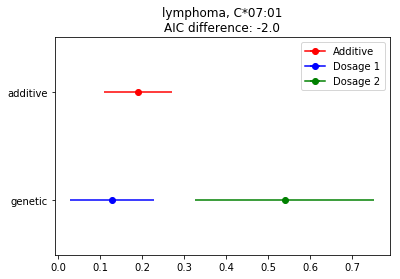

In [185]:

save_path = outpath + "compare_OR_plot/below_thresh/"
for allele in sub_df_2.columns.values:
    for phe in sub_df_2.index.values:
        if sub_df_2[allele][phe] < AIC_thresh: 
            compare_OR_plot(phe,allele, gen_logOR_1, gen_logOR_2, gen_std_1, gen_std_2, add_logOR, add_std, sub_df_2, save_path)

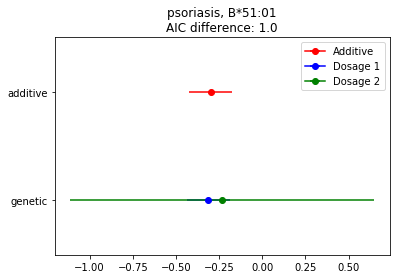

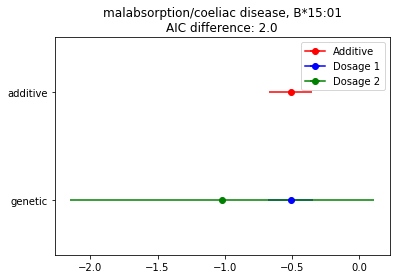

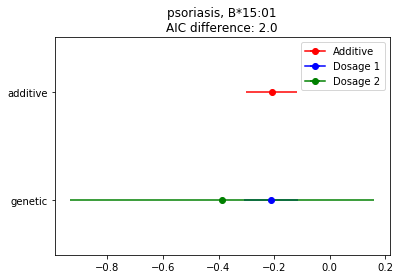

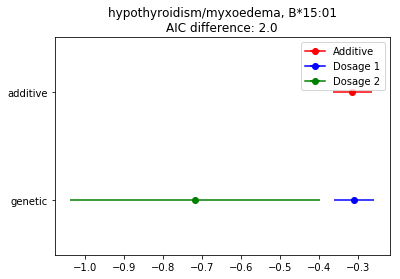

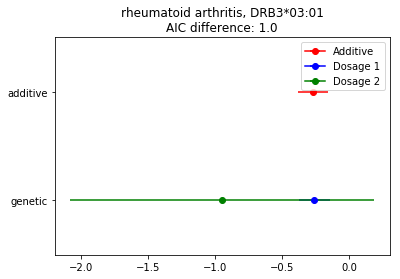

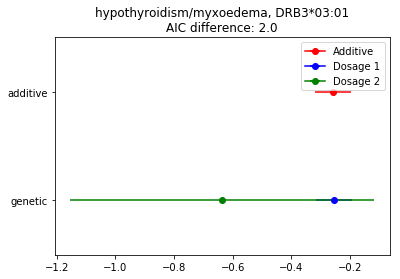

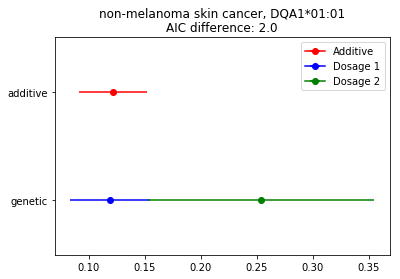

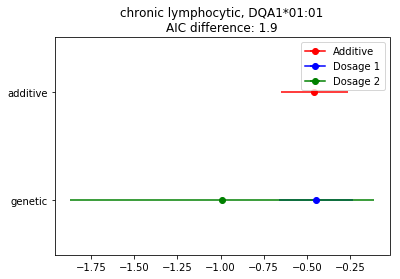

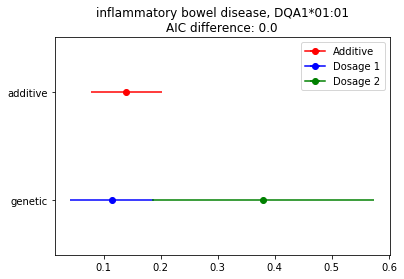

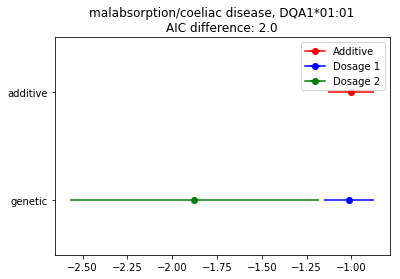

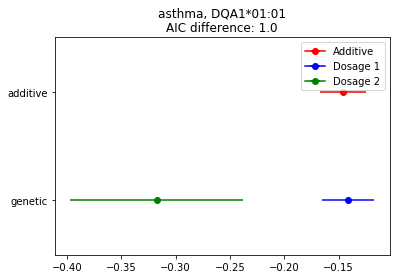

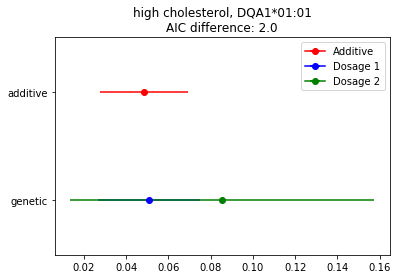

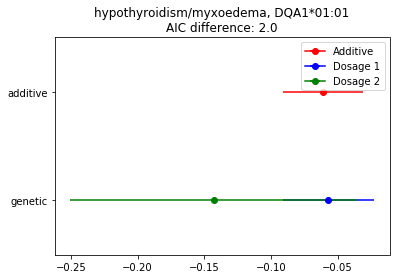

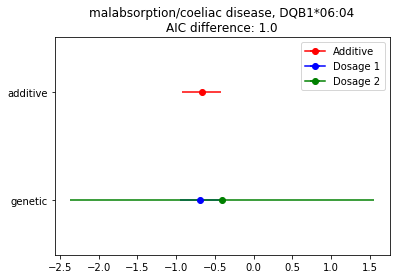

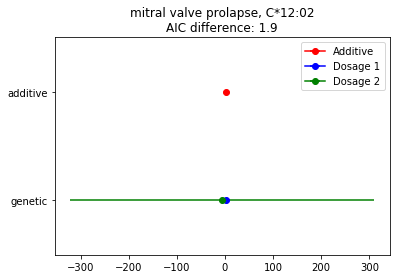

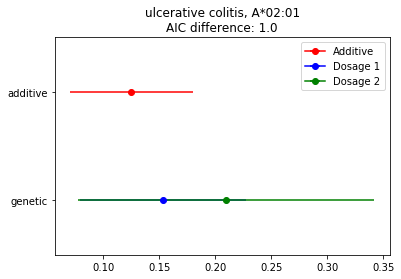

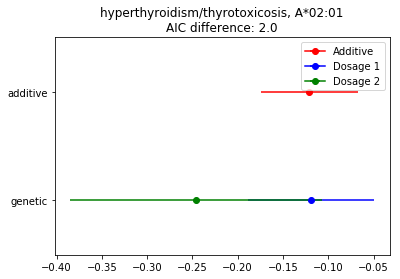

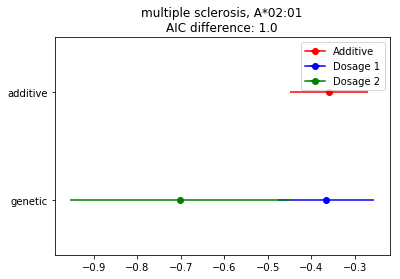

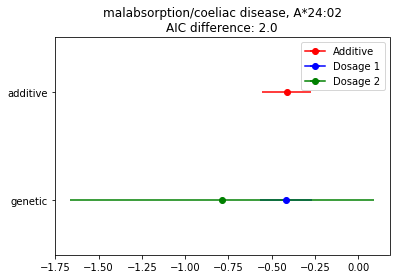

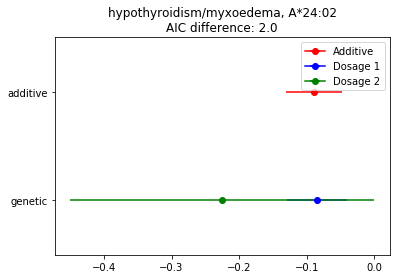

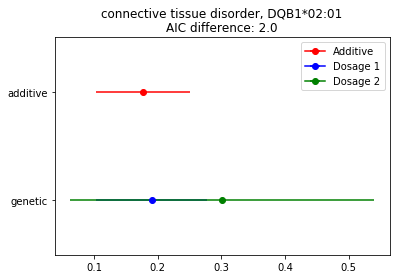

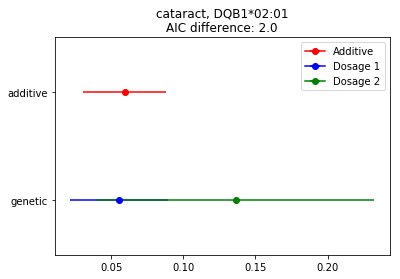

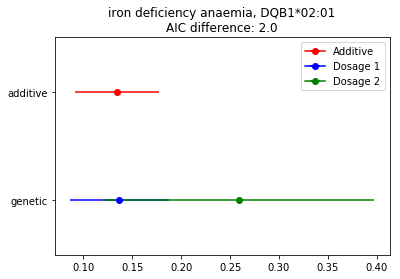

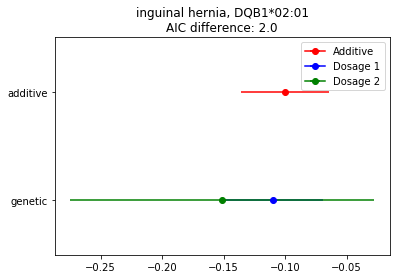

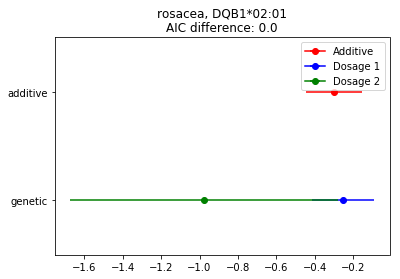

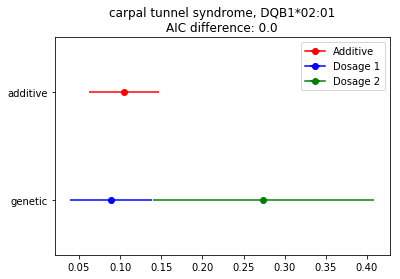

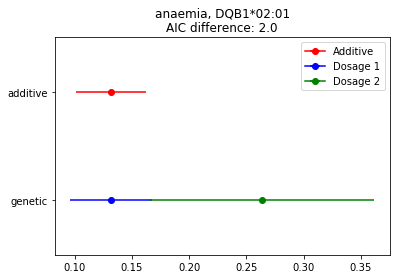

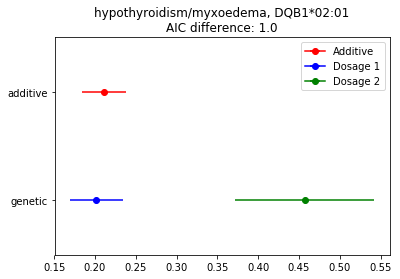

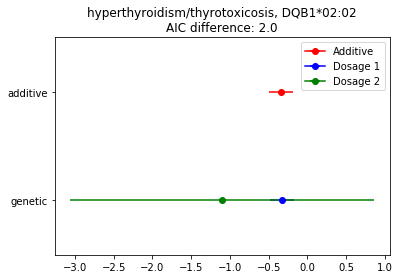

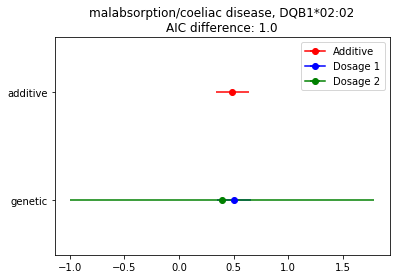

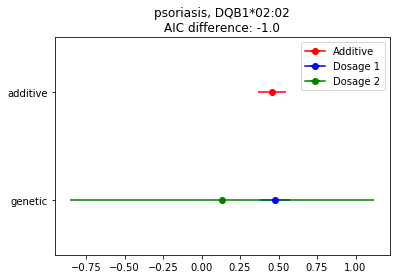

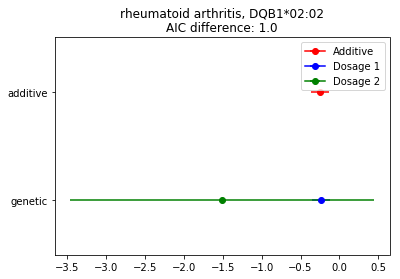

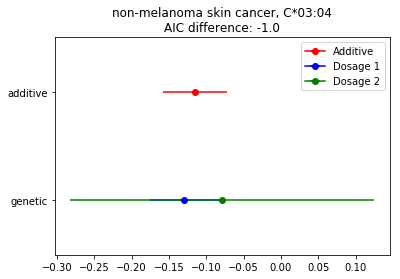

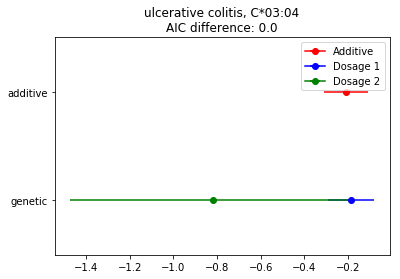

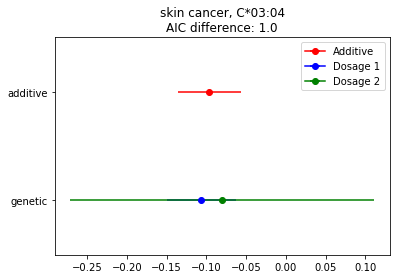

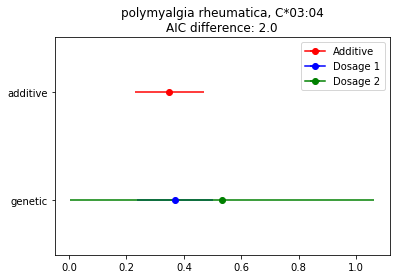

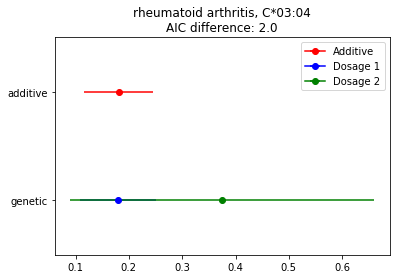

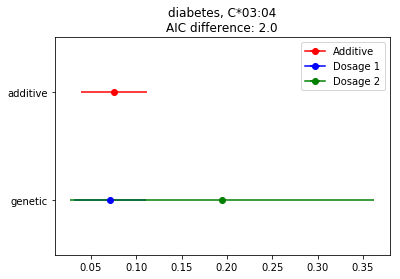

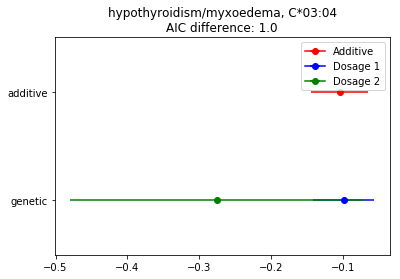

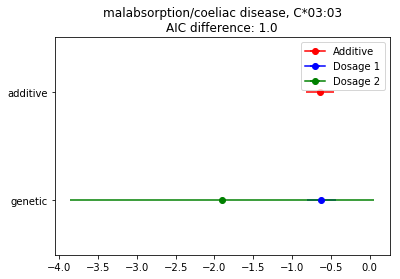

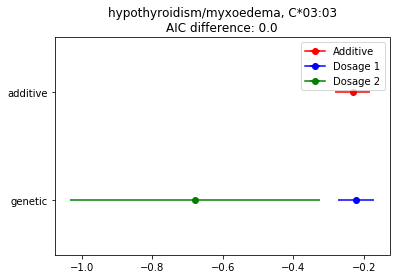

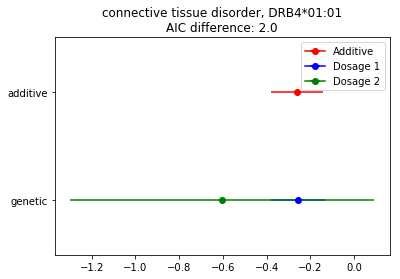

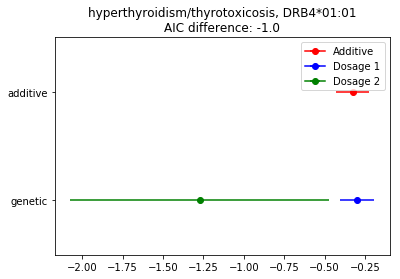

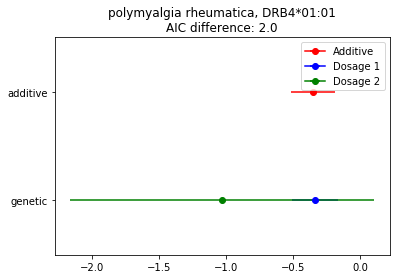

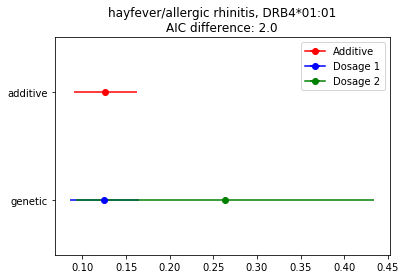

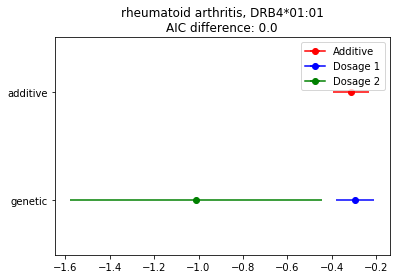

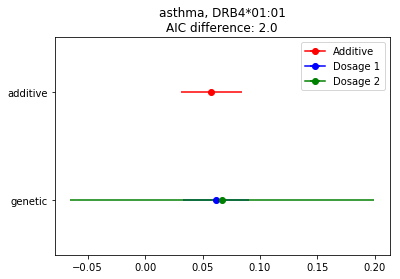

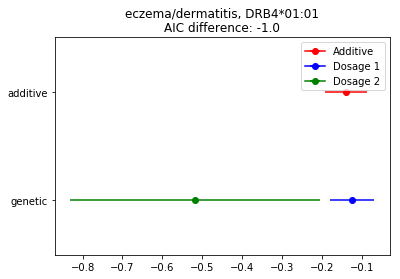

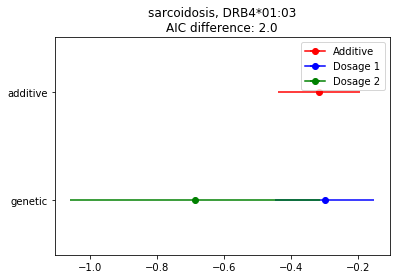

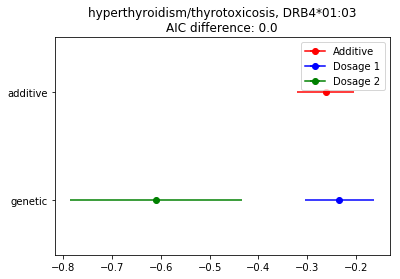

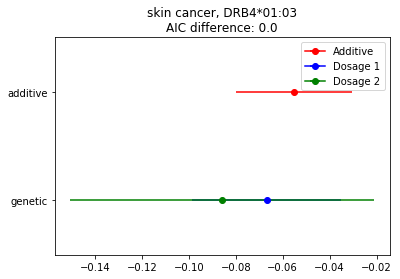

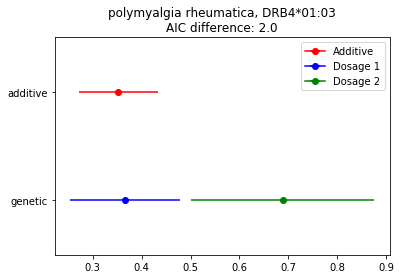

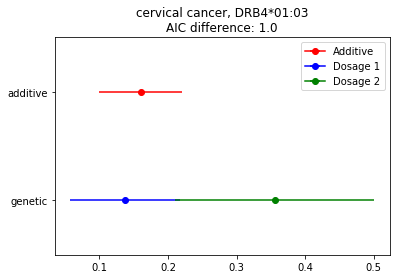

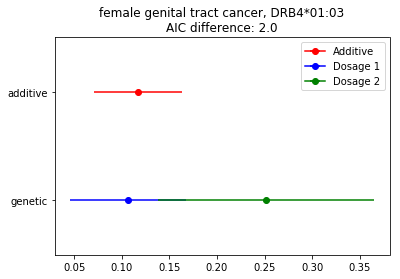

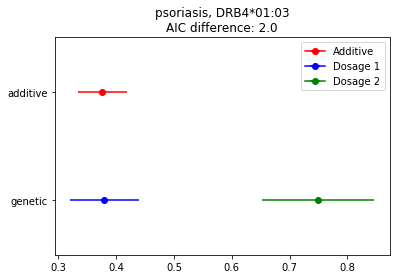

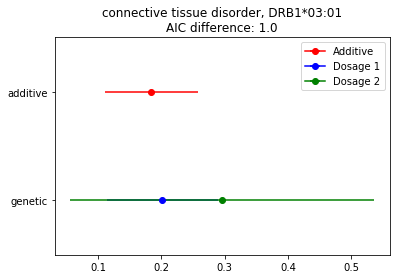

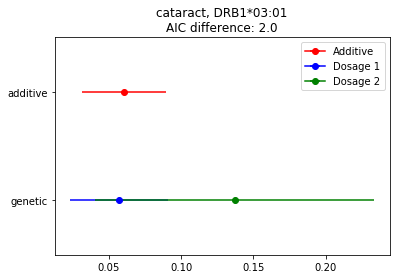

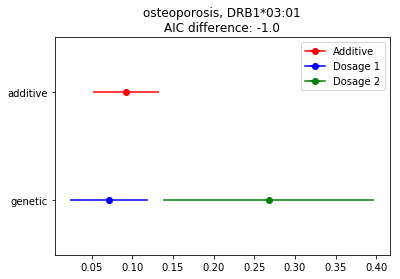

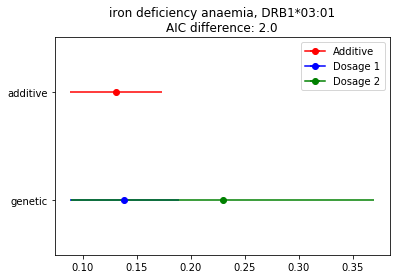

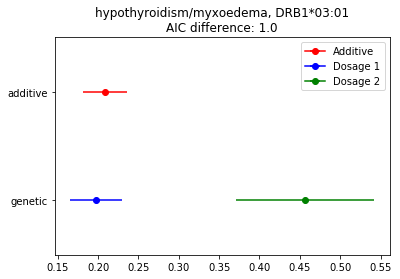

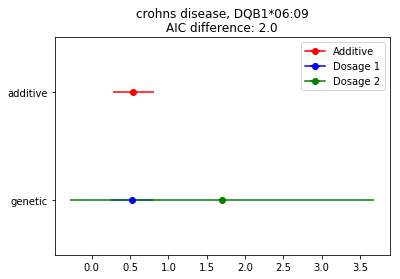

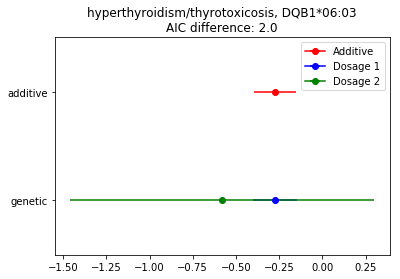

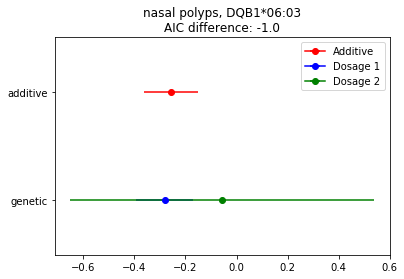

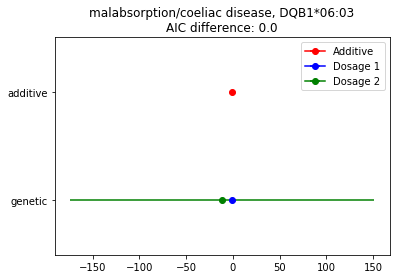

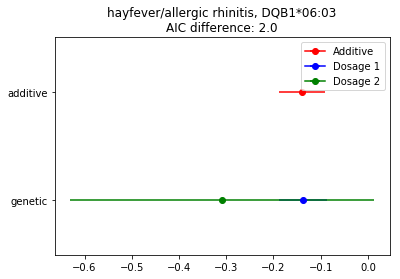

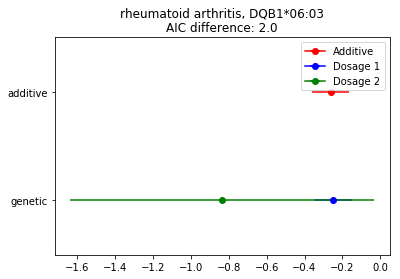

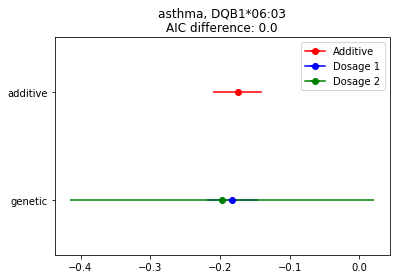

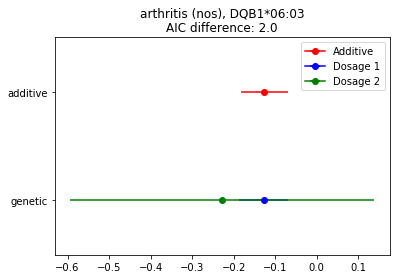

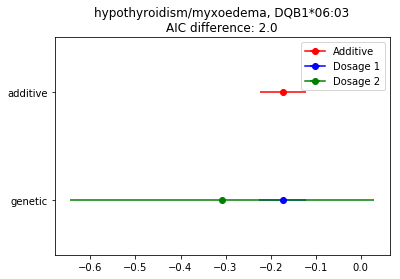

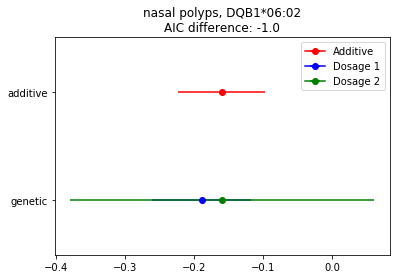

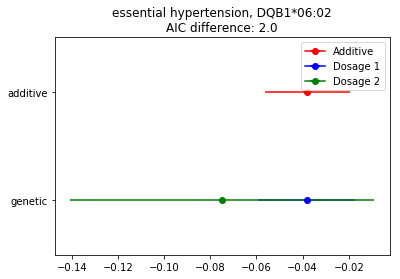

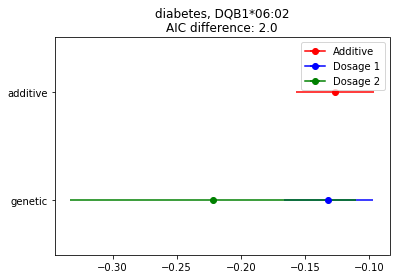

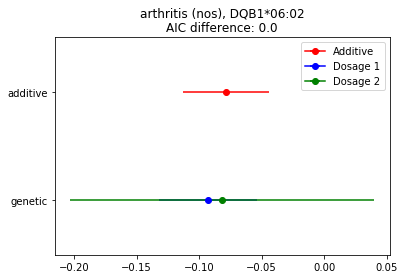

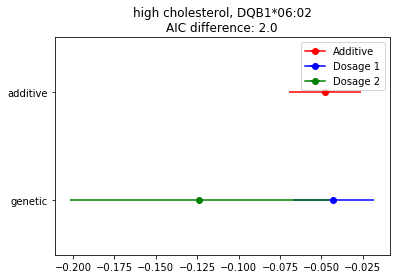

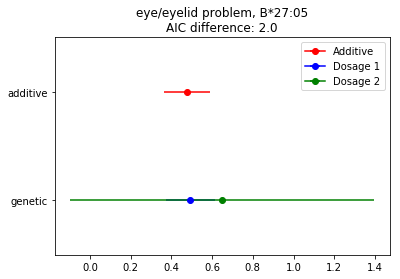

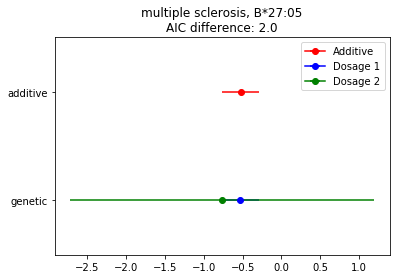

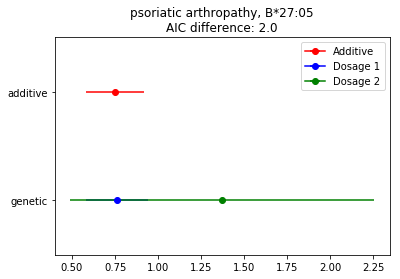

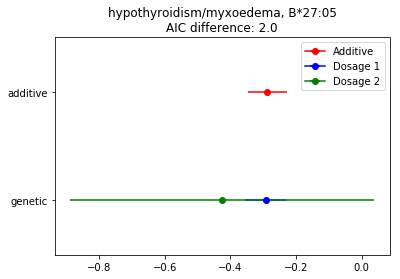

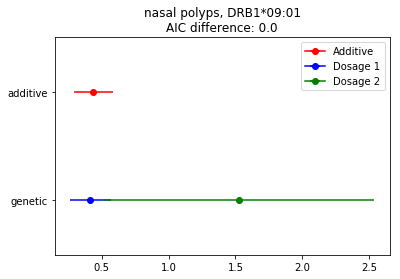

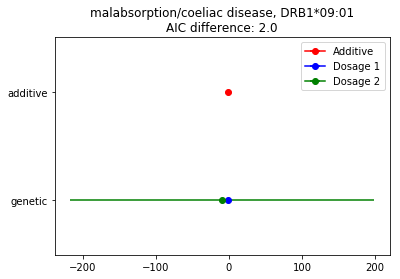

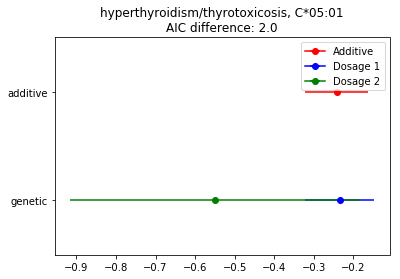

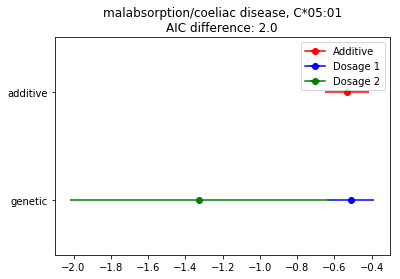

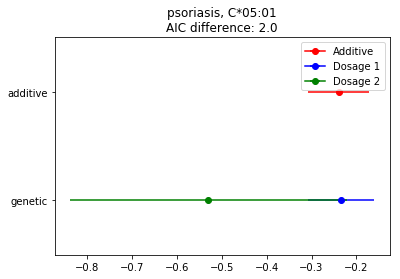

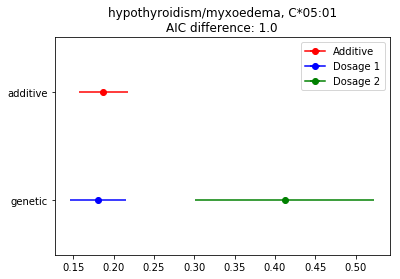

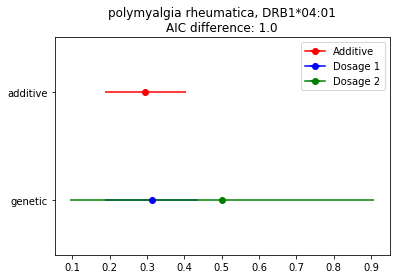

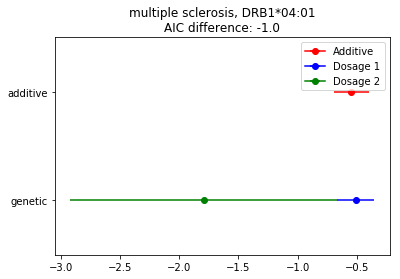

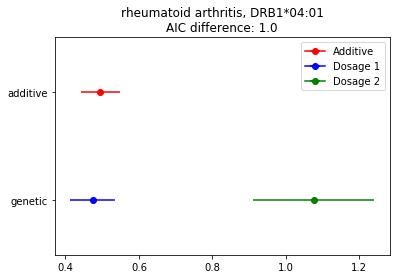

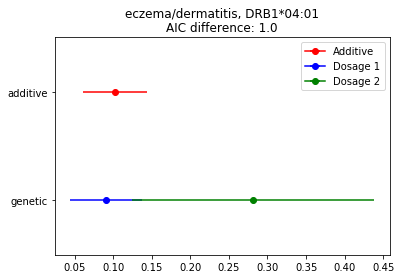

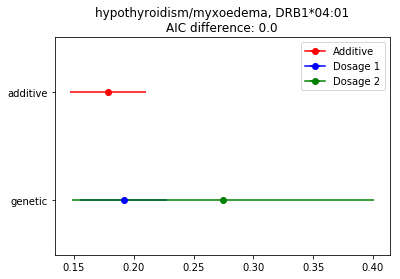

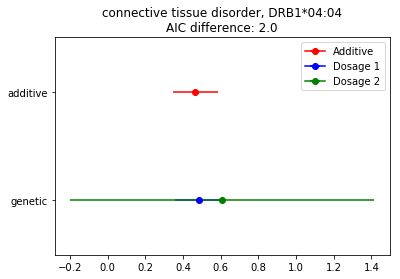

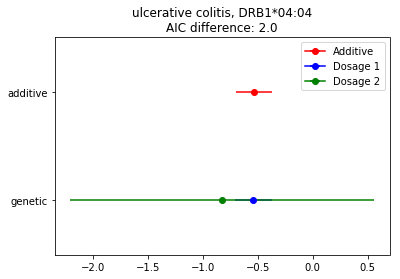

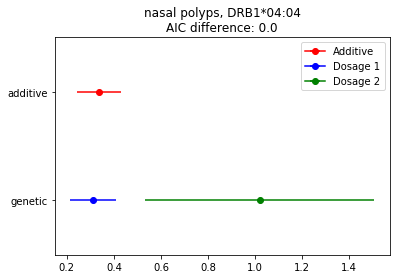

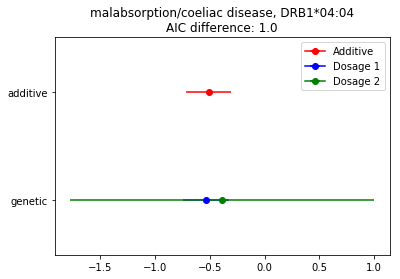

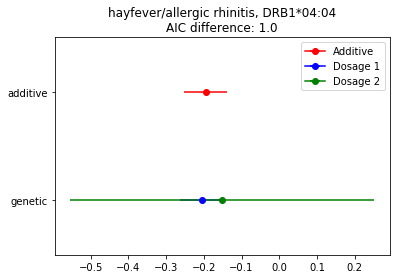

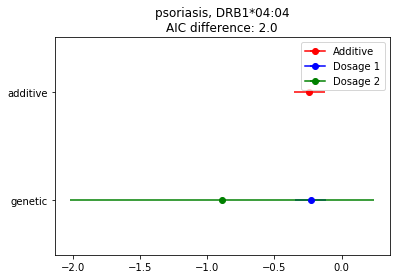

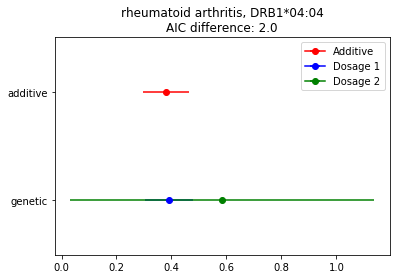

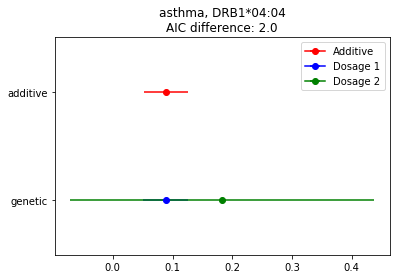

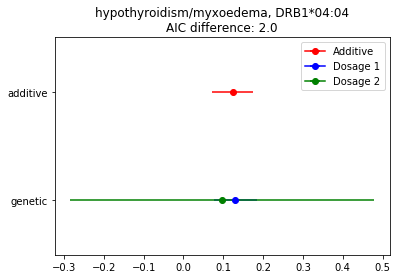

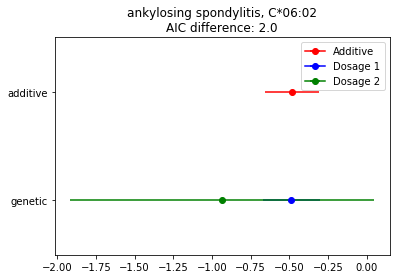

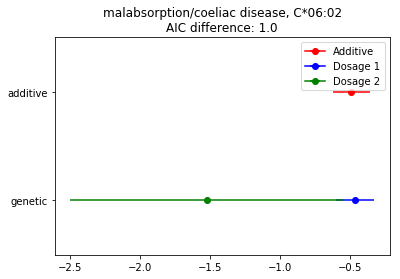

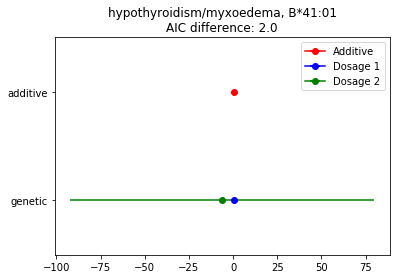

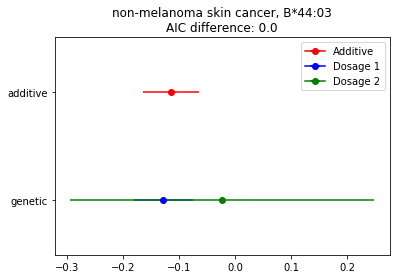

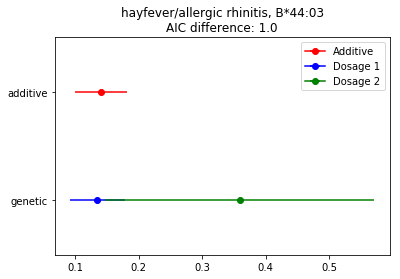

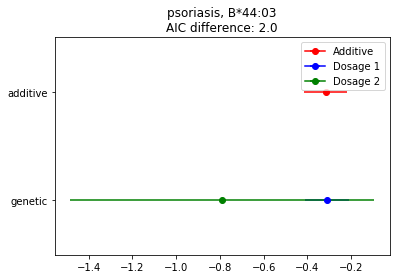

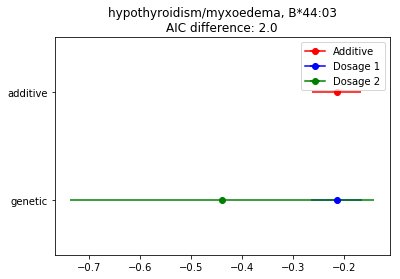

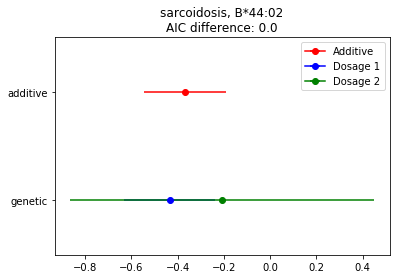

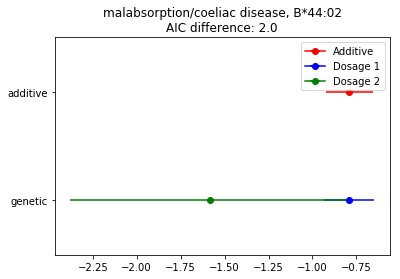

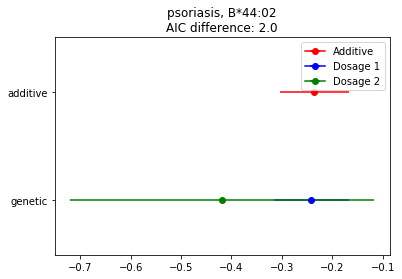

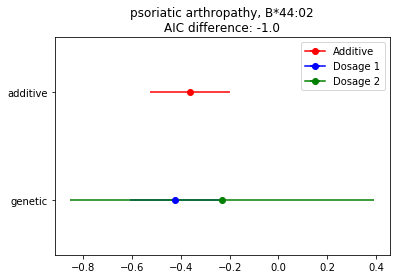

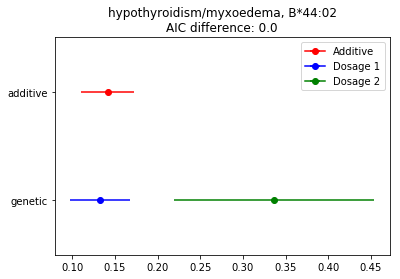

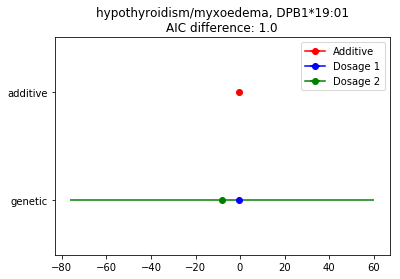

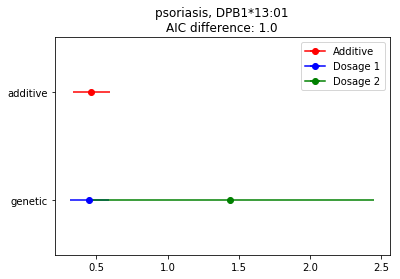

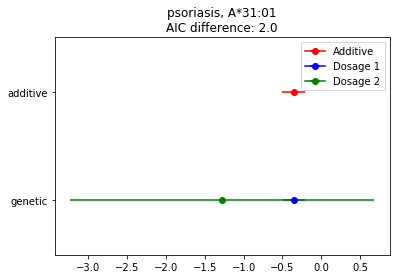

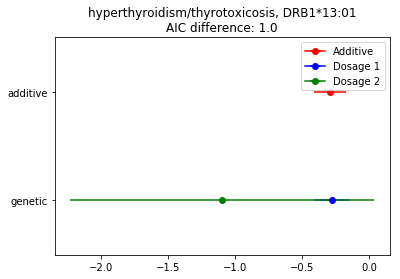

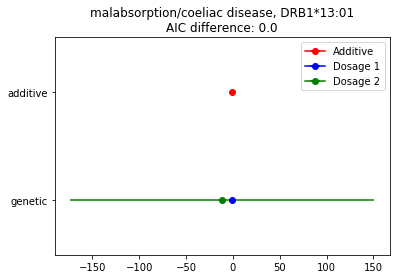

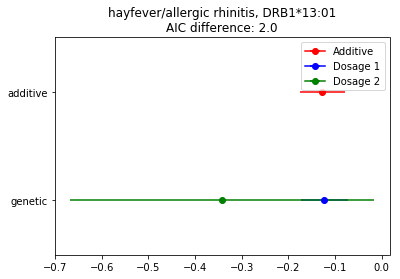

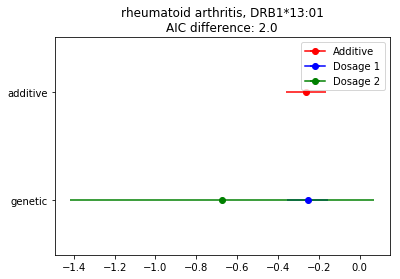

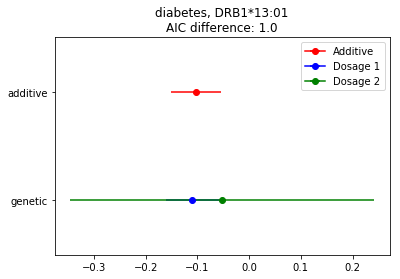

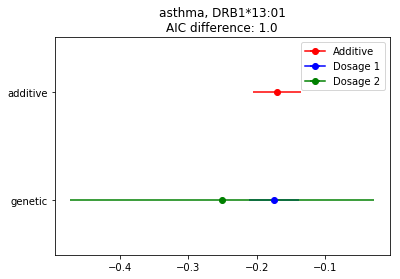

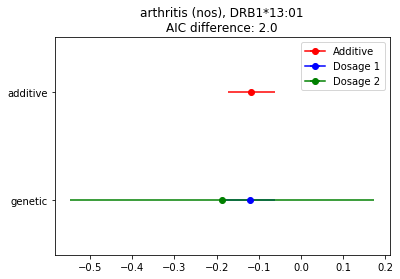

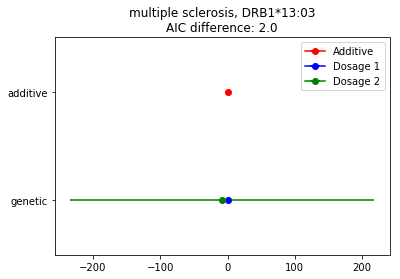

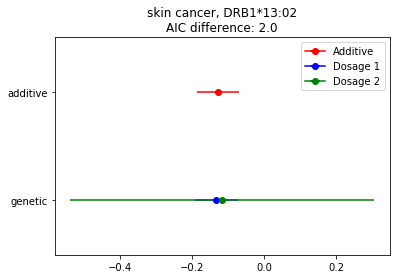

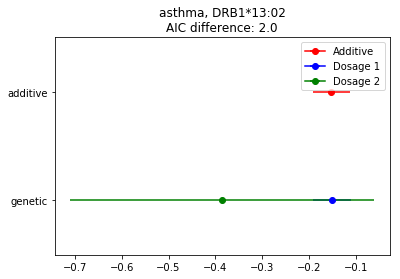

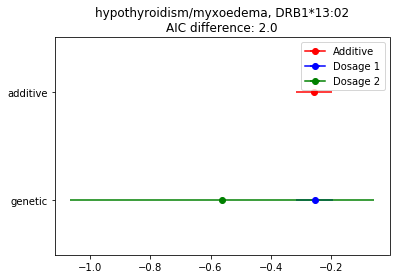

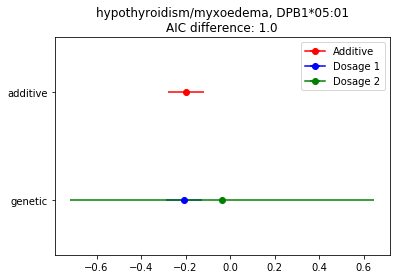

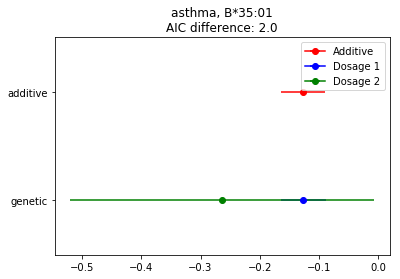

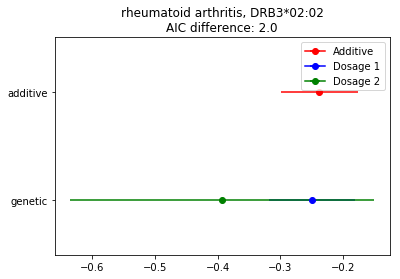

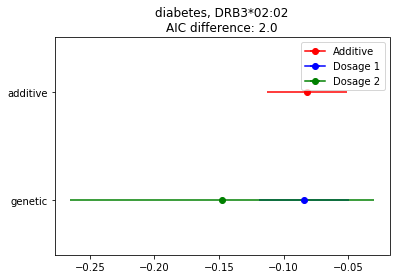

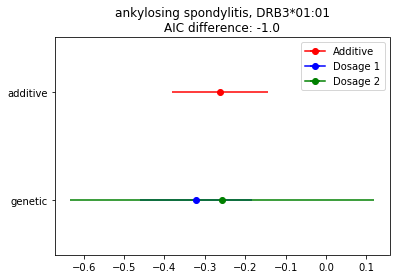

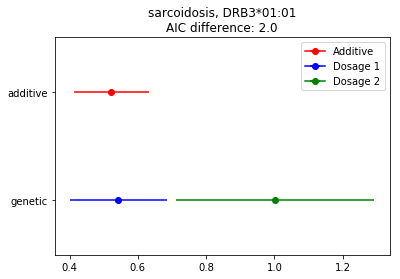

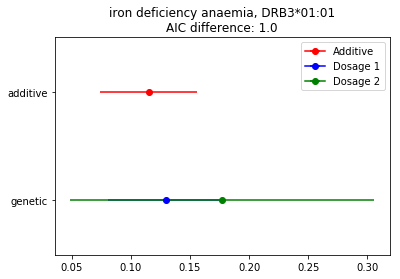

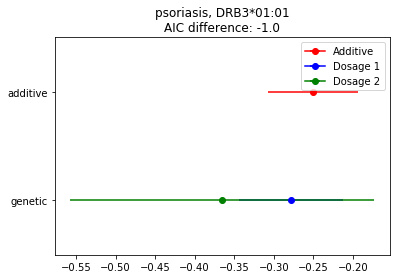

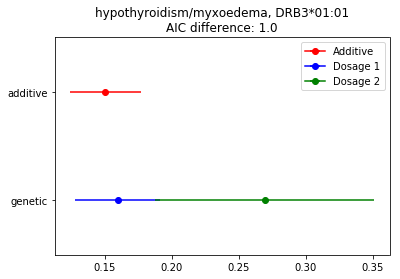

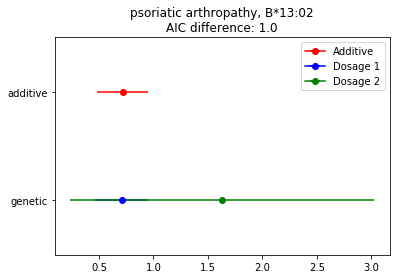

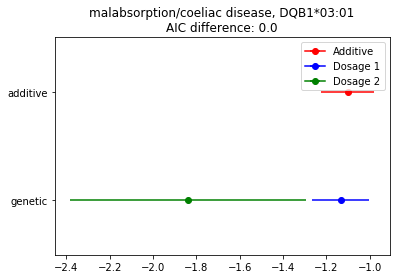

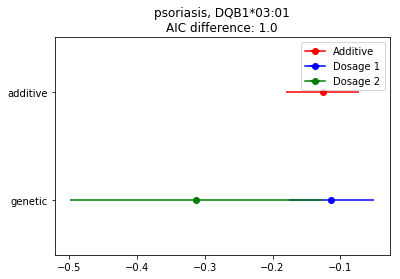

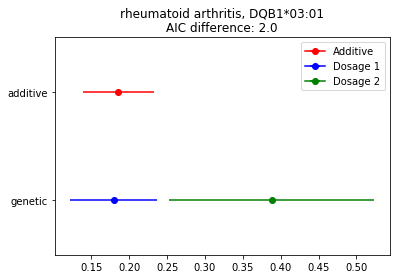

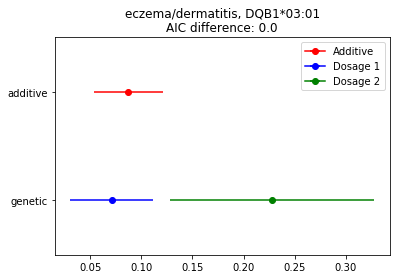

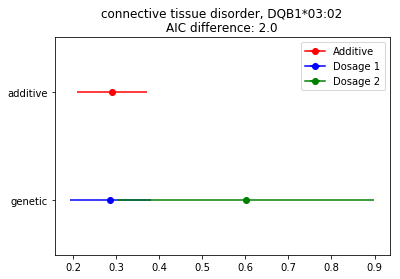

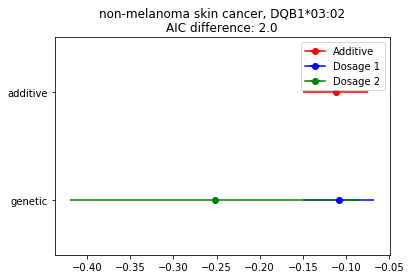

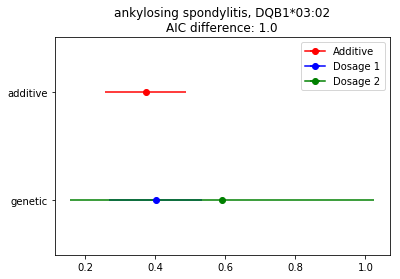

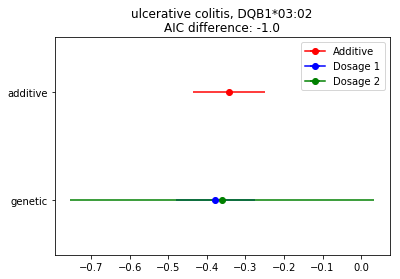

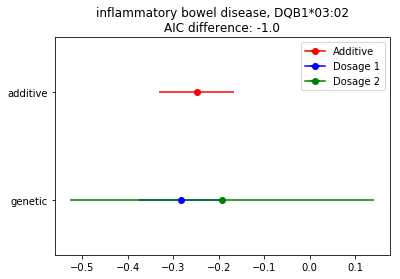

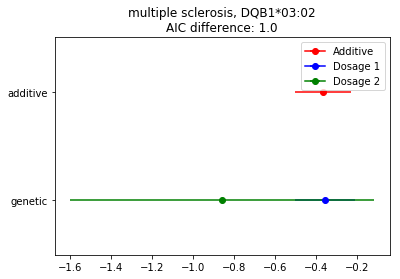

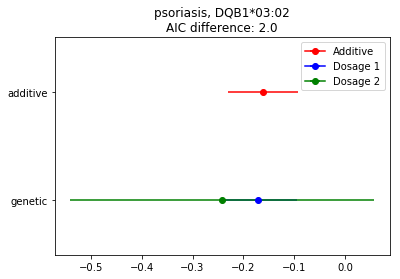

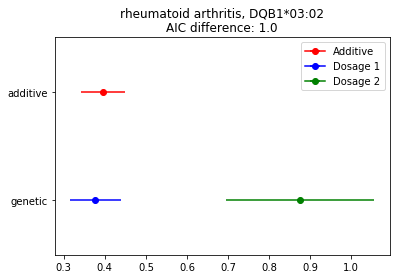

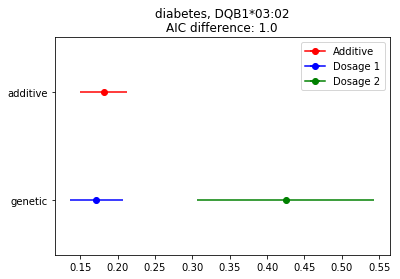

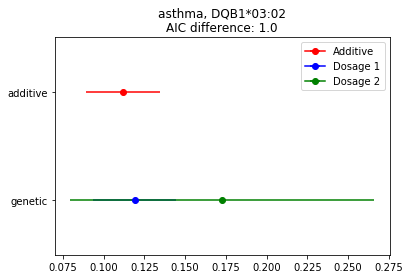

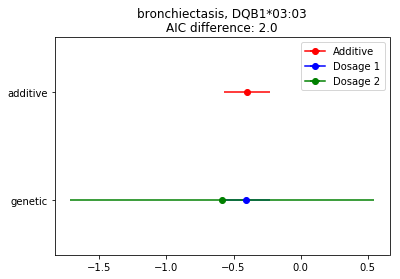

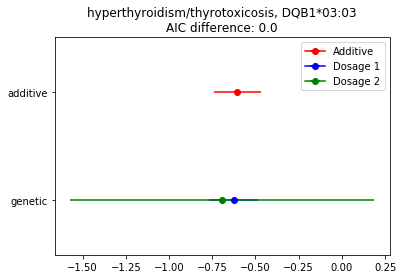

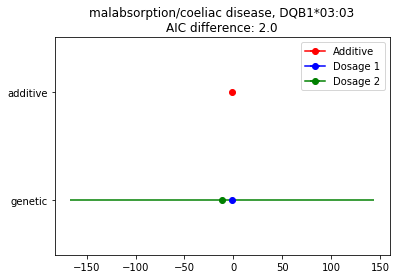

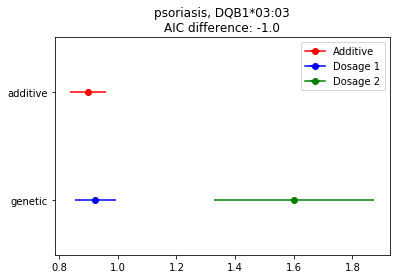

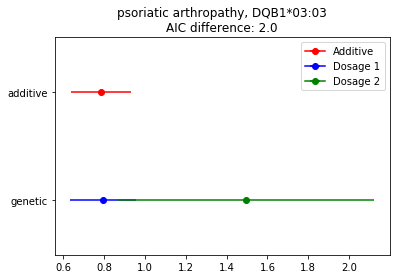

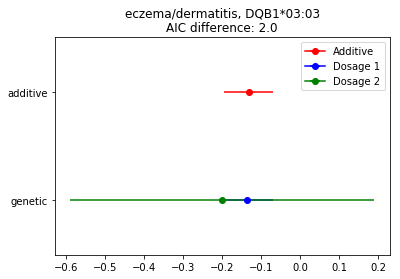

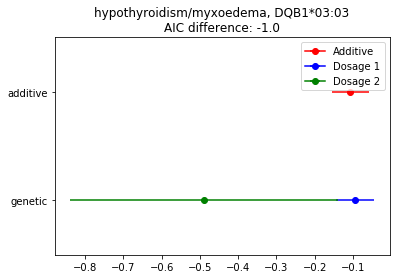

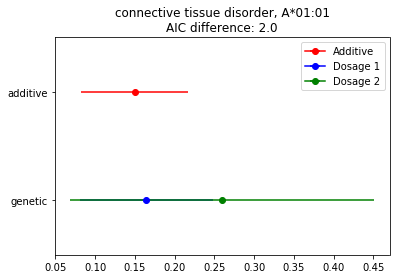

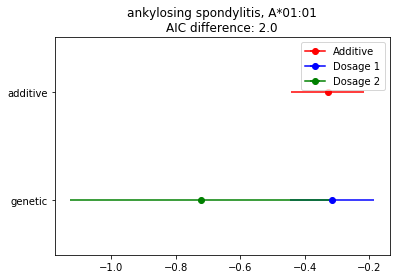

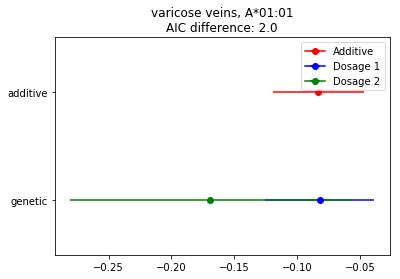

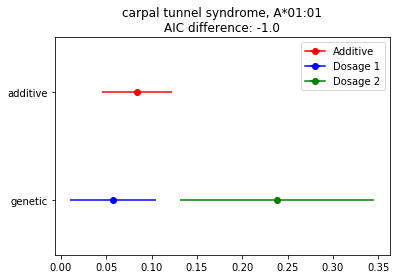

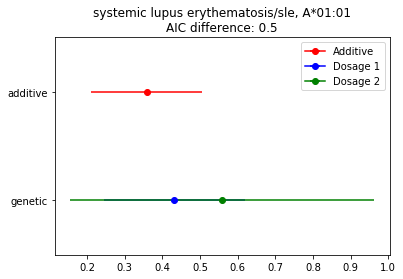

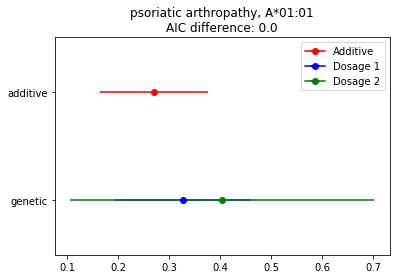

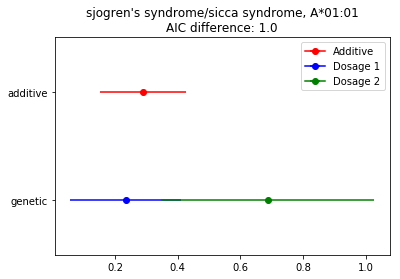

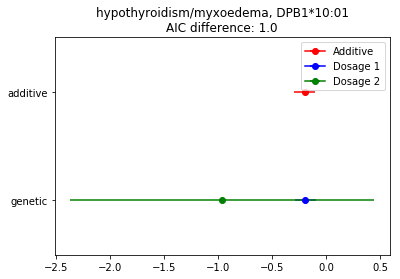

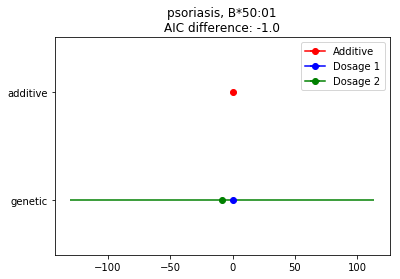

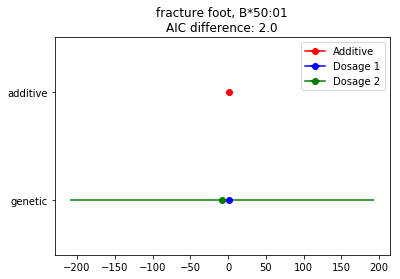

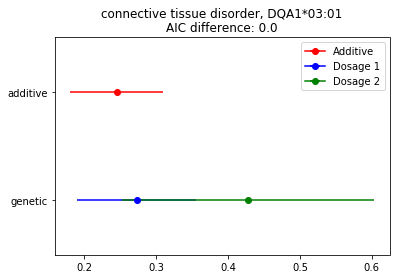

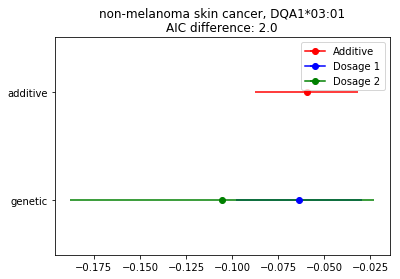

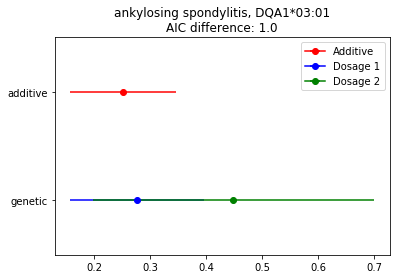

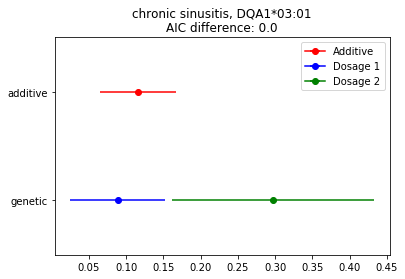

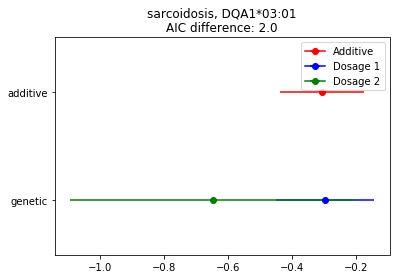

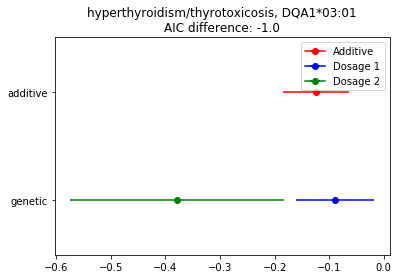

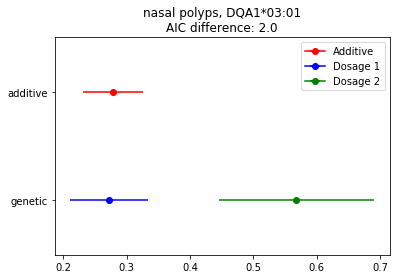

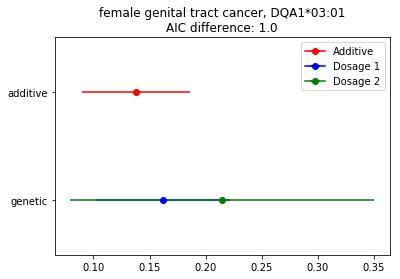

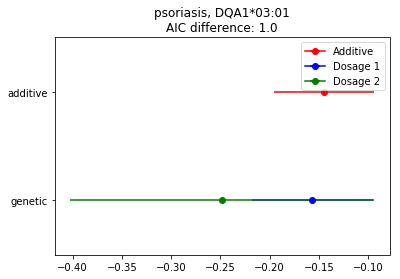

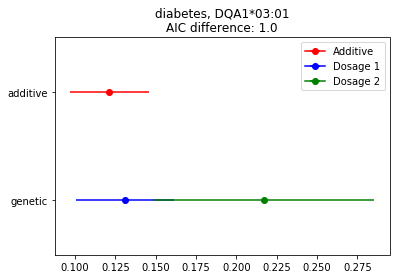

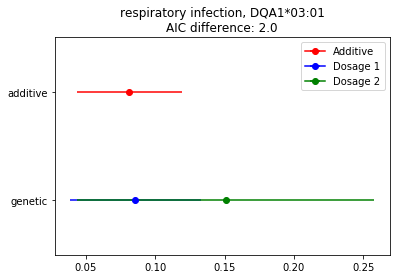

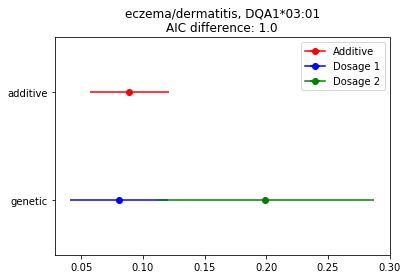

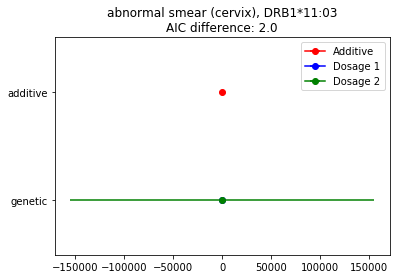

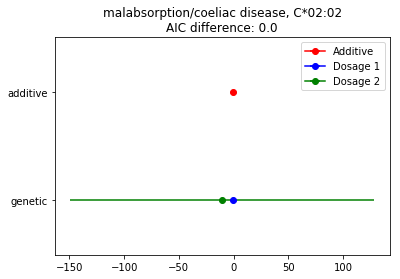

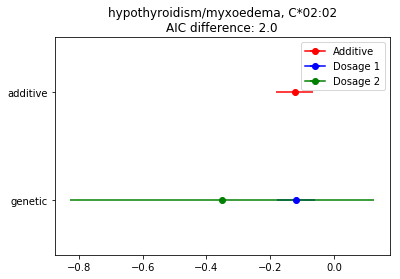

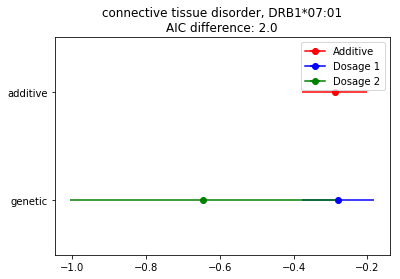

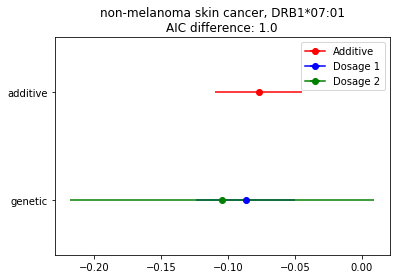

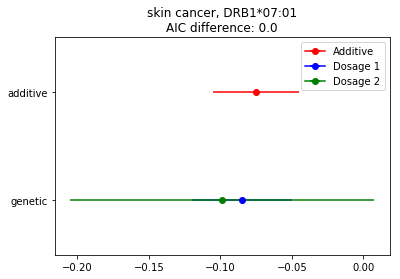

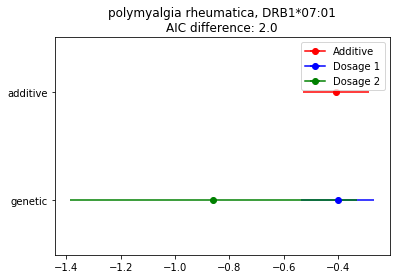

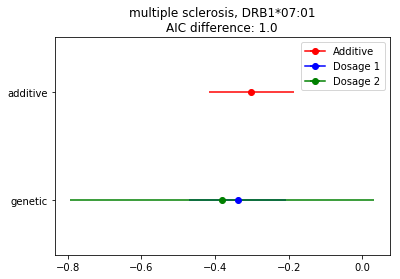

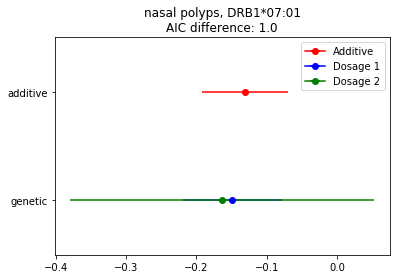

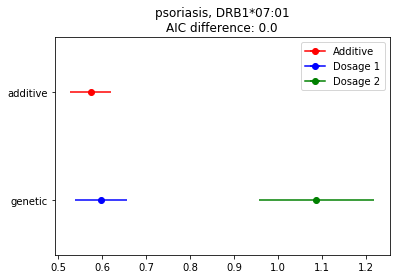

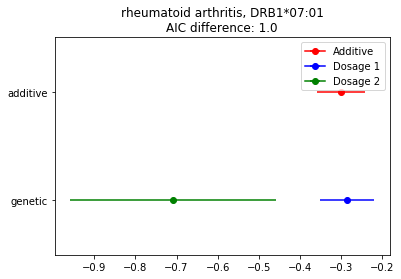

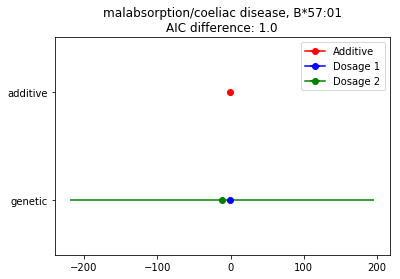

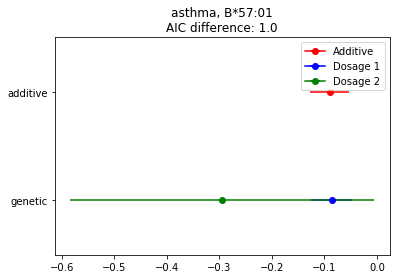

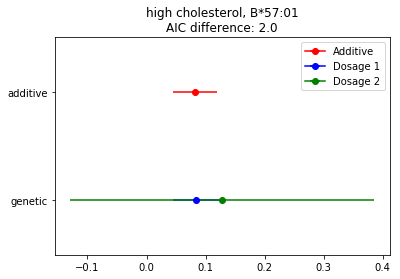

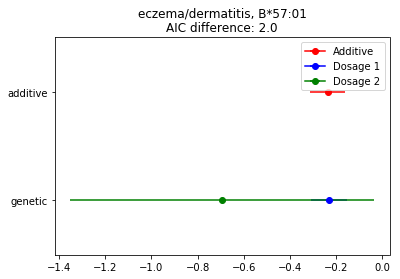

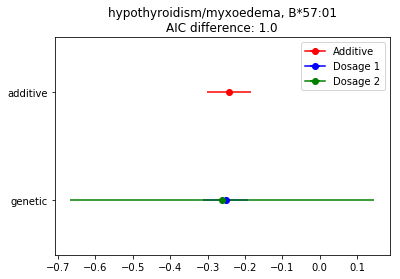

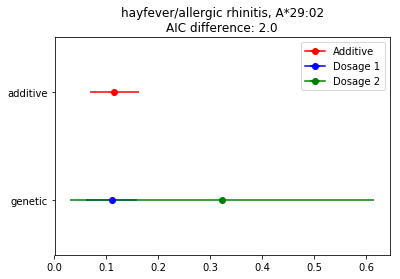

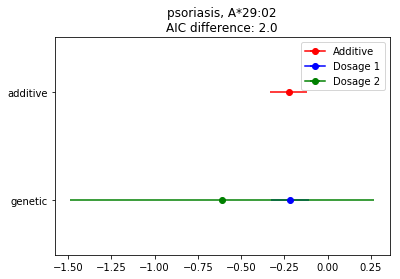

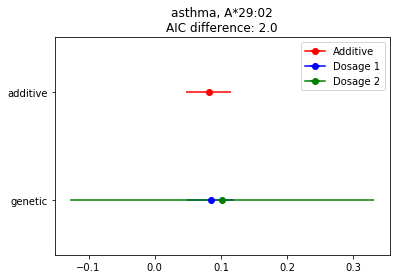

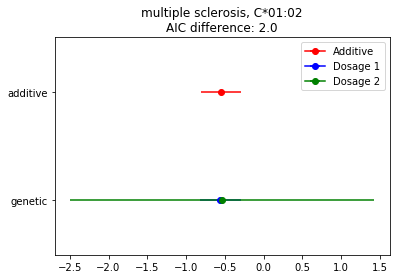

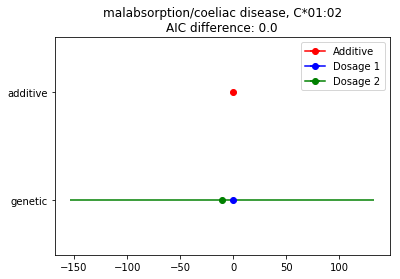

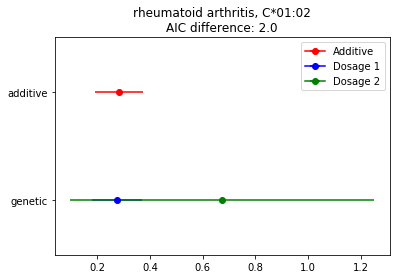

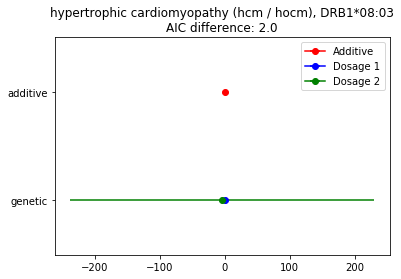

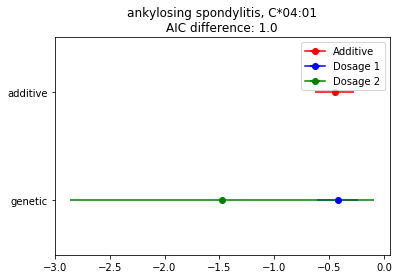

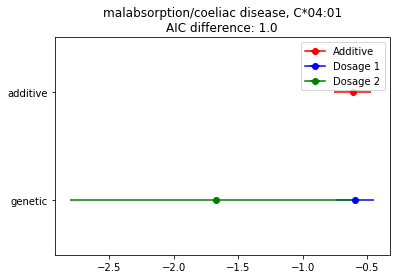

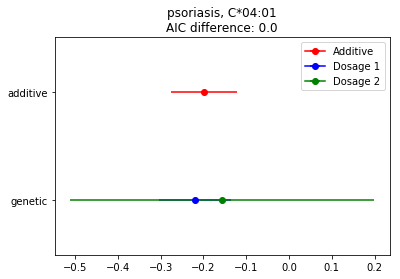

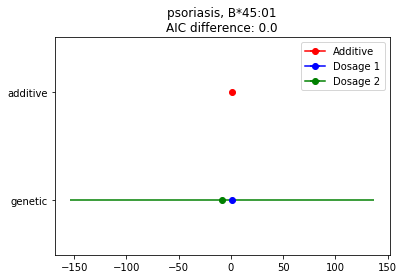

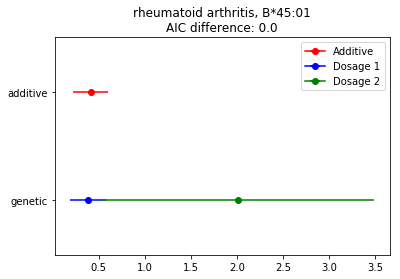

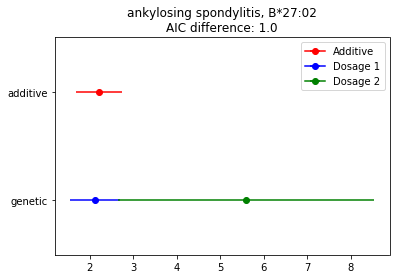

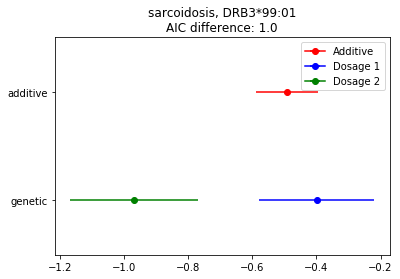

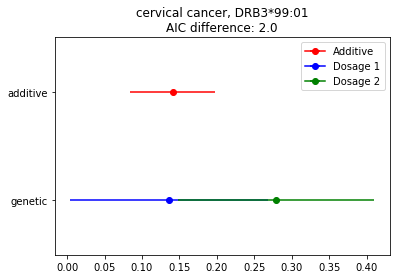

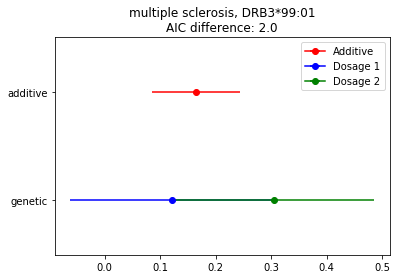

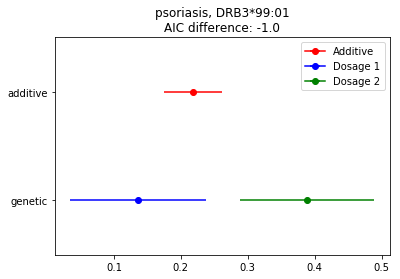

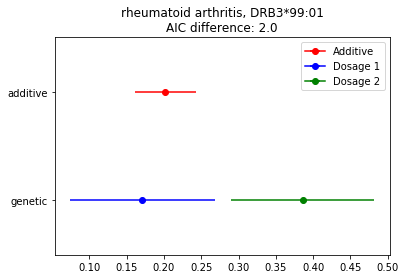

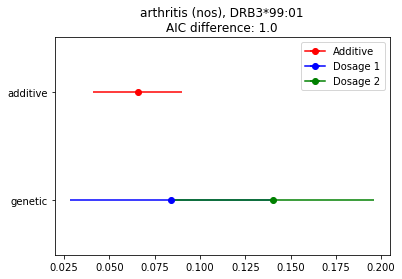

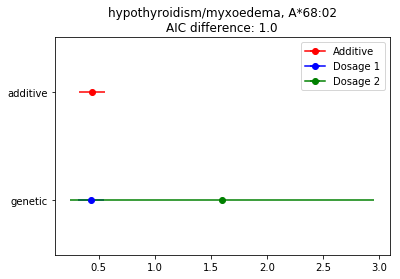

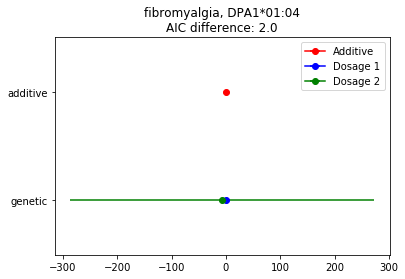

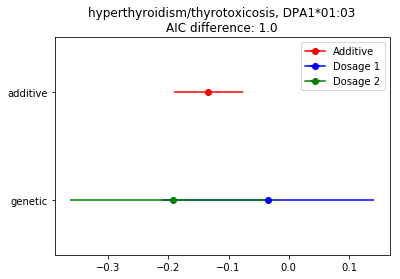

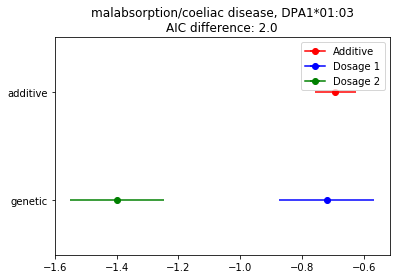

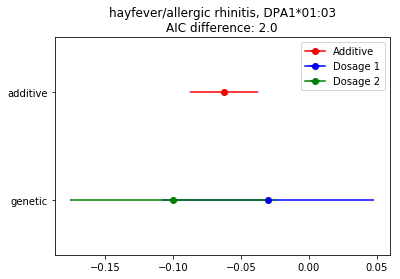

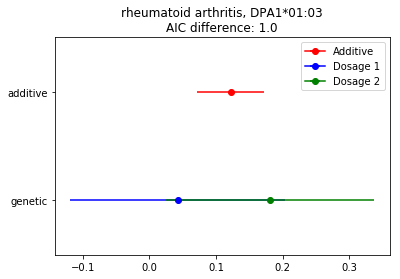

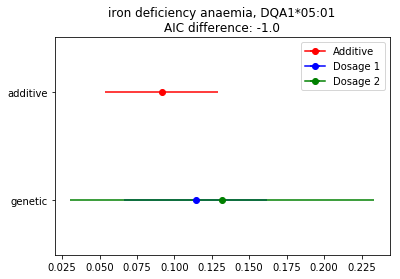

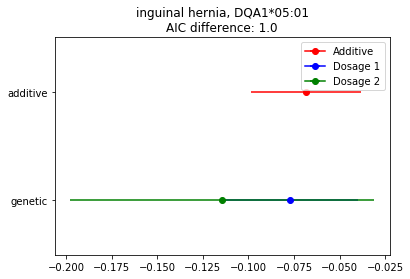

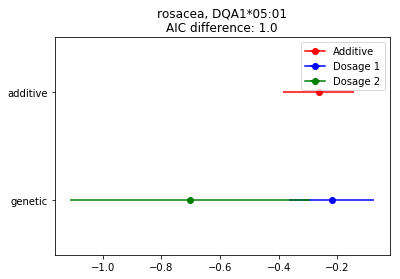

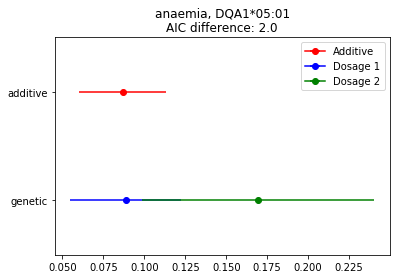

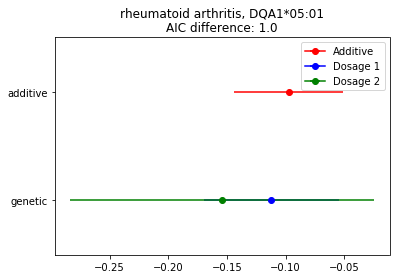

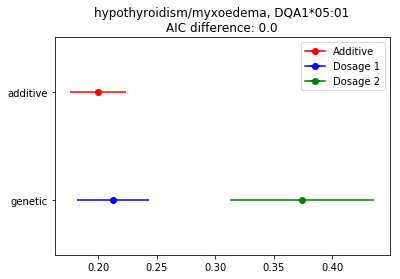

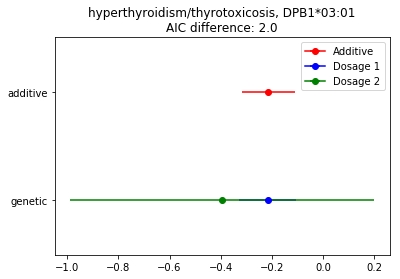

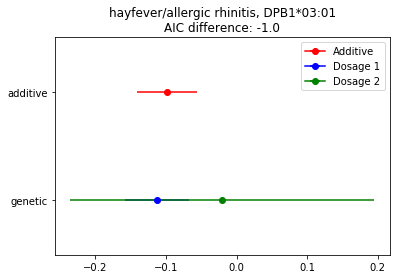

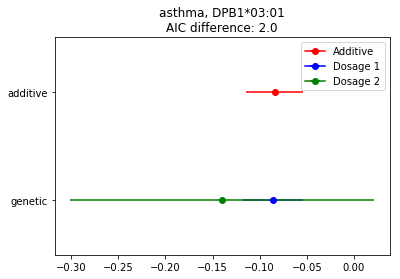

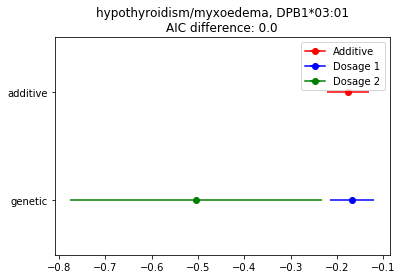

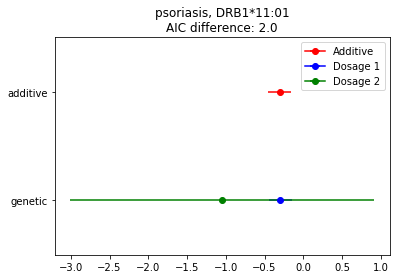

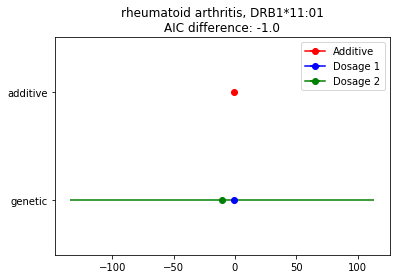

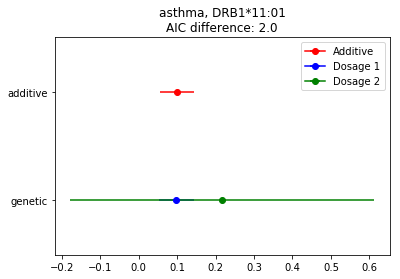

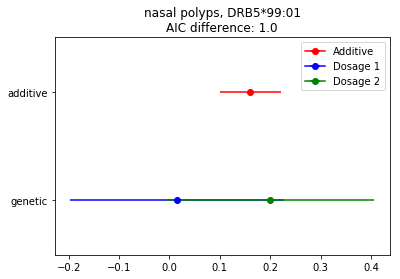

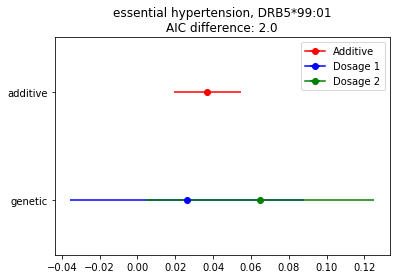

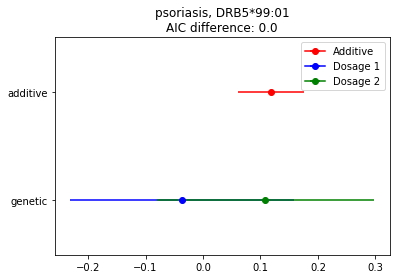

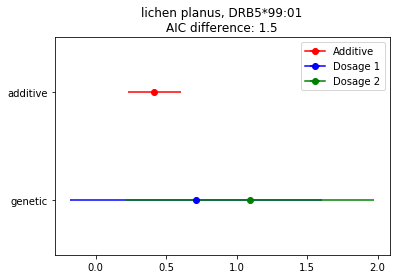

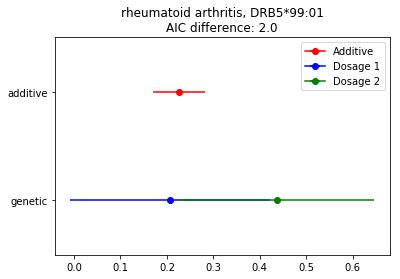

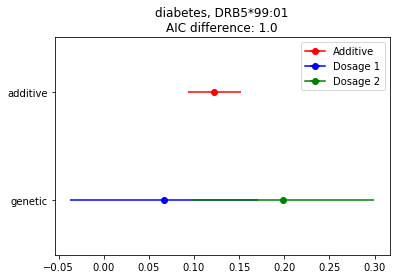

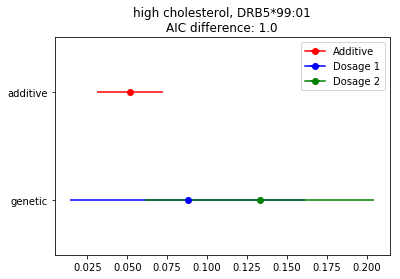

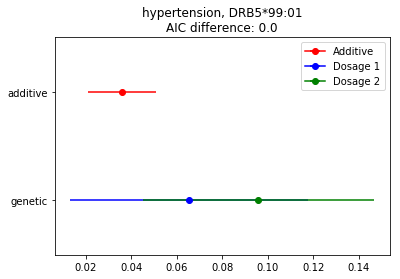

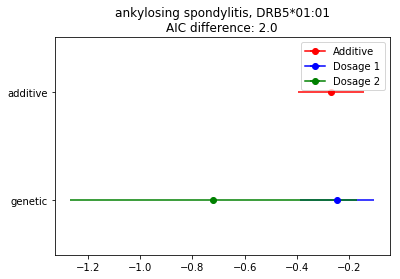

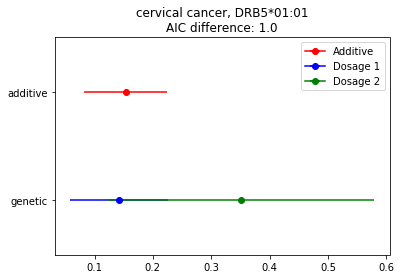

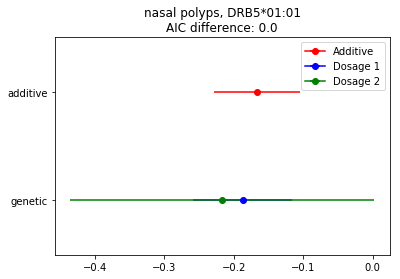

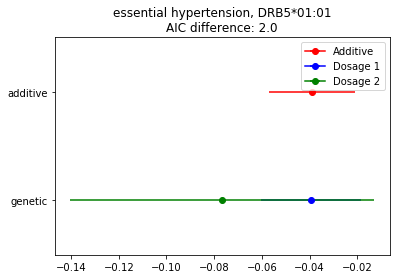

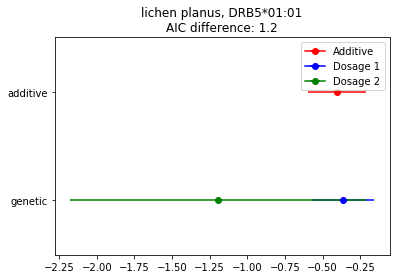

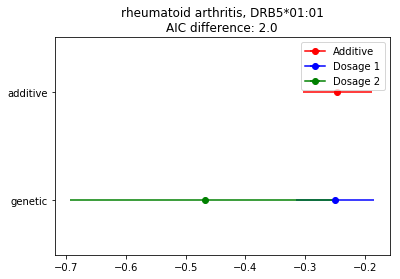

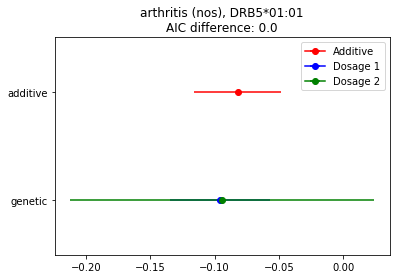

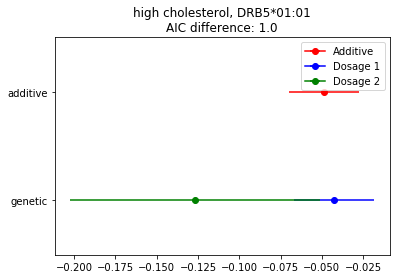

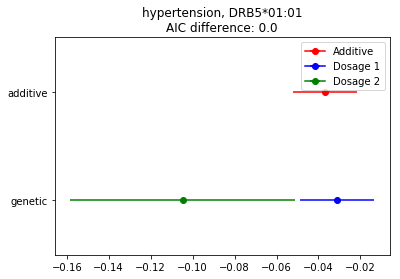

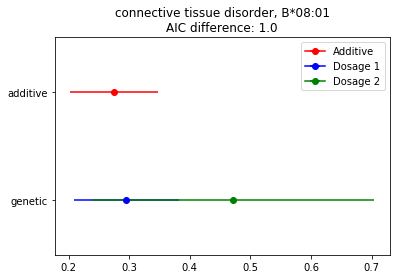

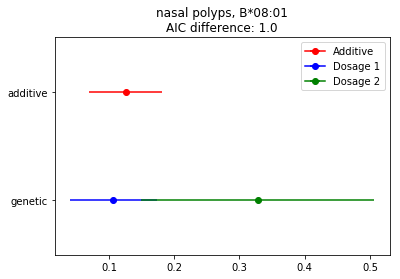

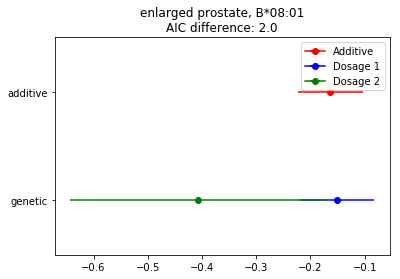

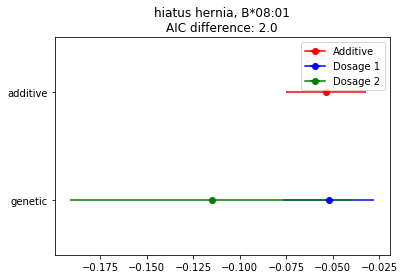

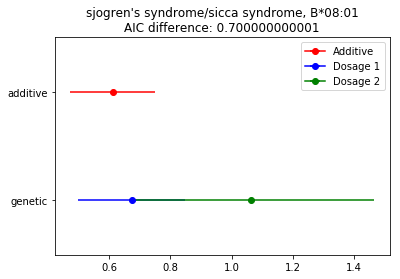

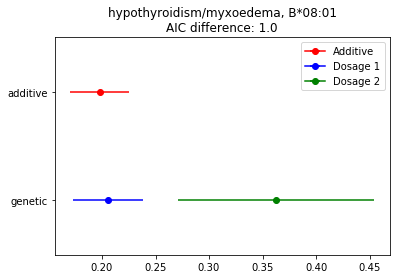

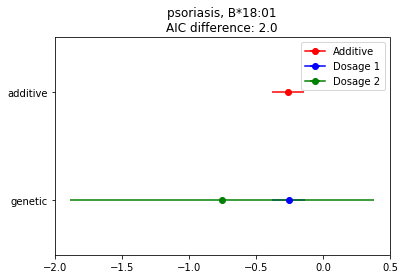

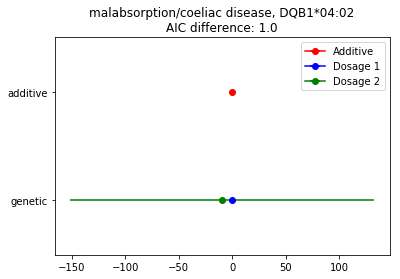

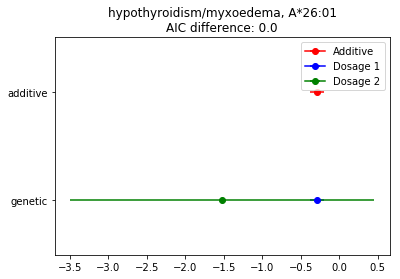

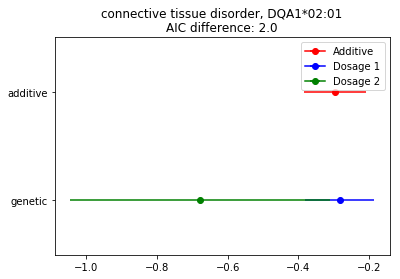

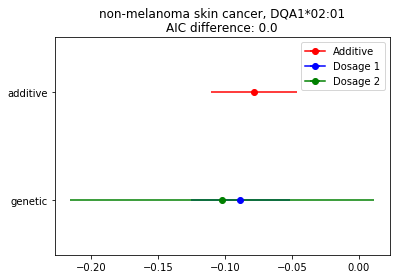

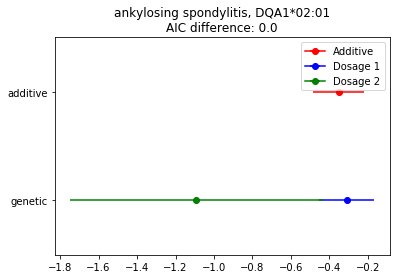

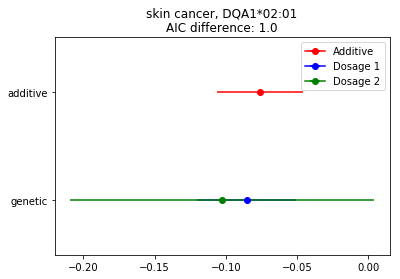

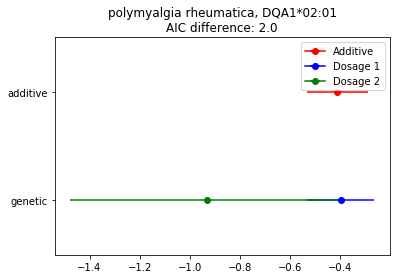

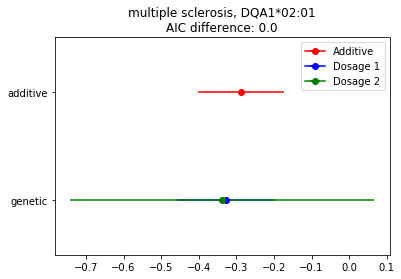

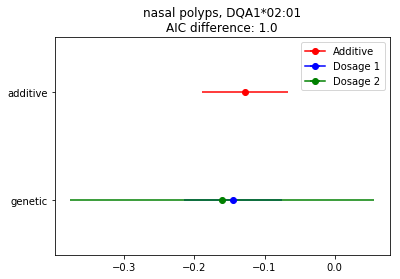

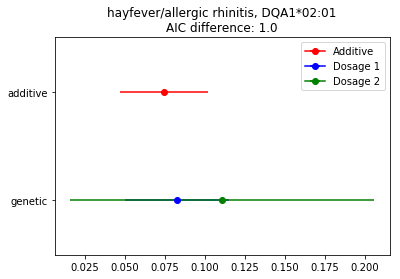

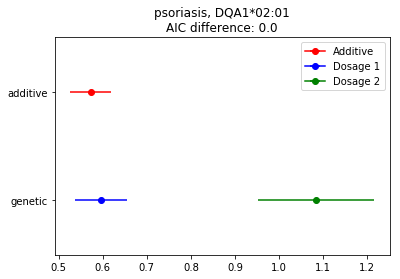

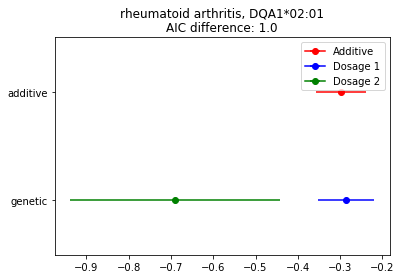

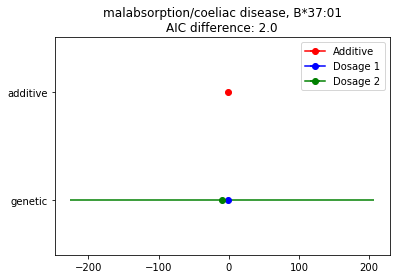

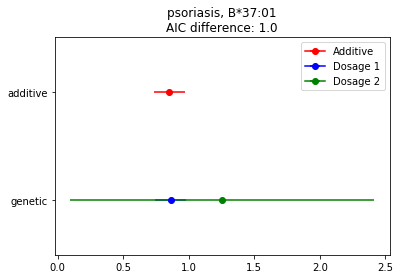

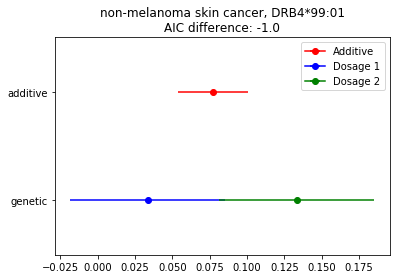

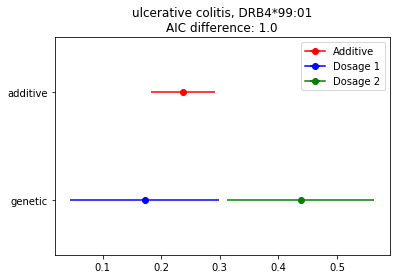

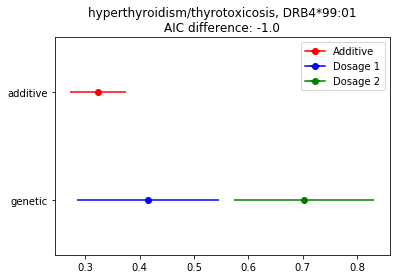

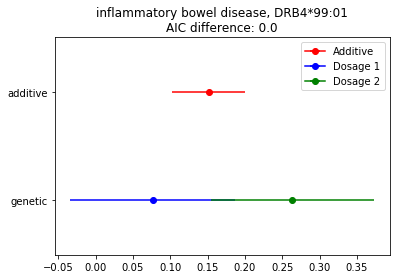

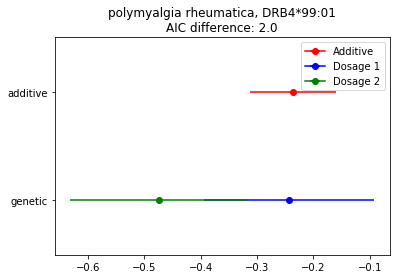

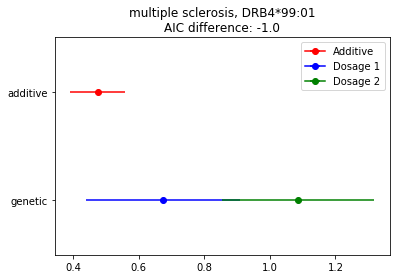

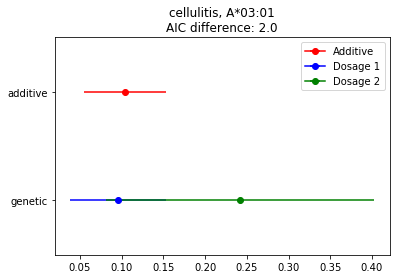

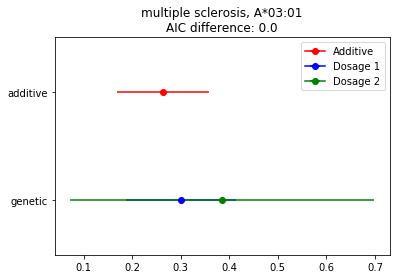

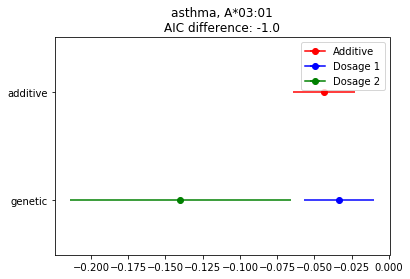

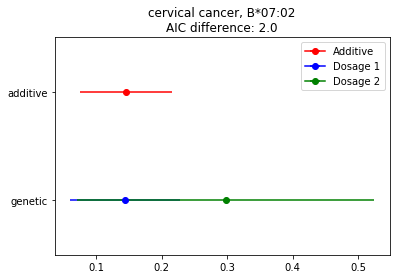

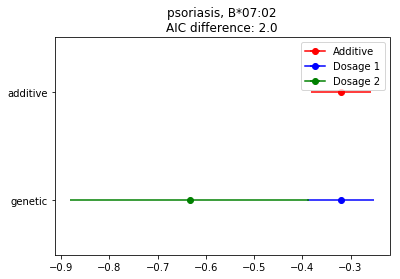

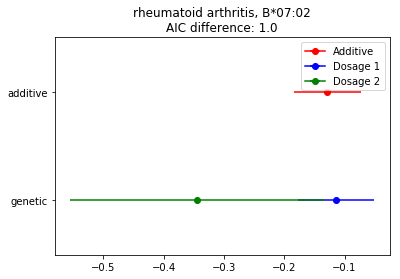

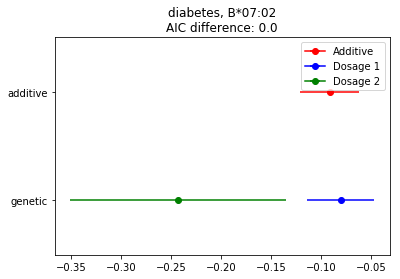

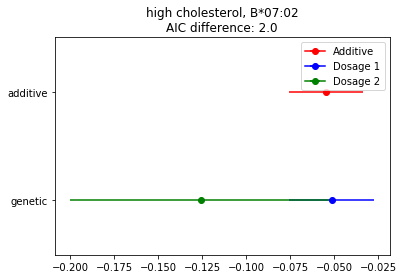

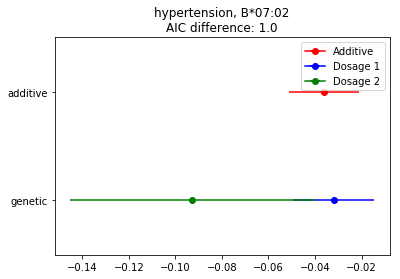

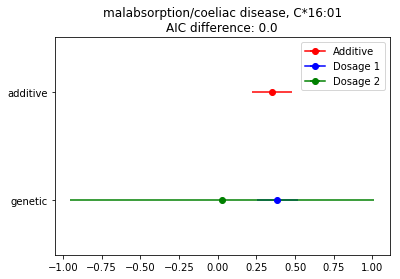

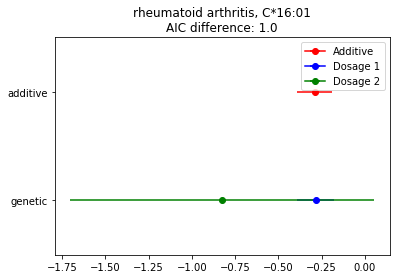

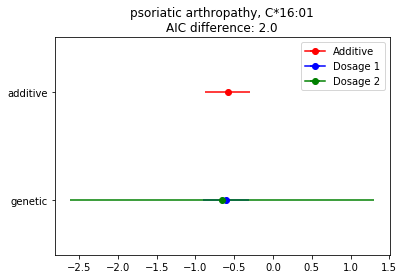

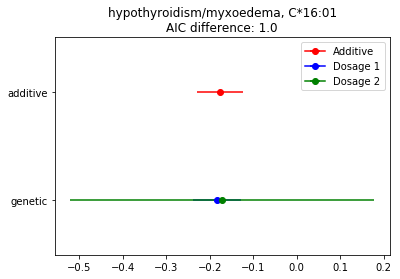

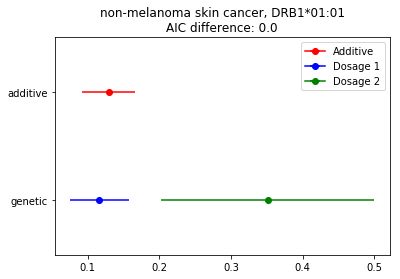

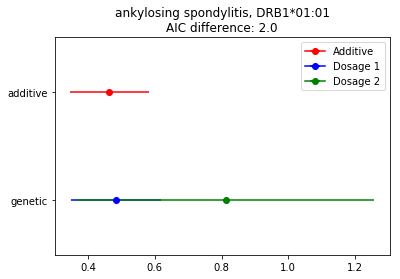

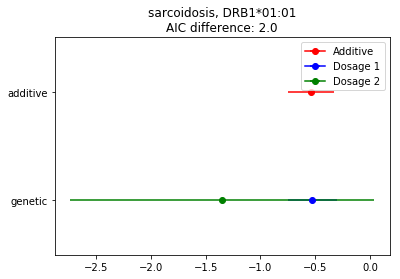

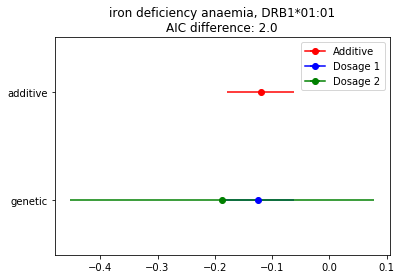

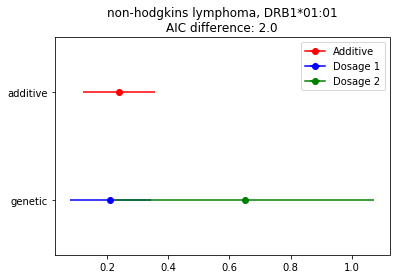

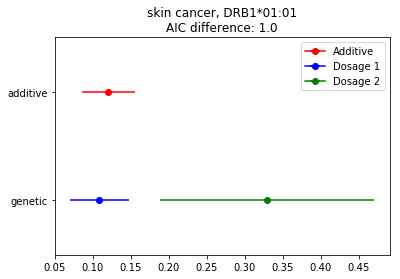

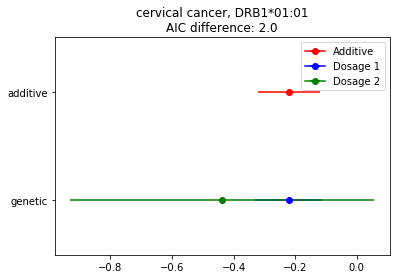

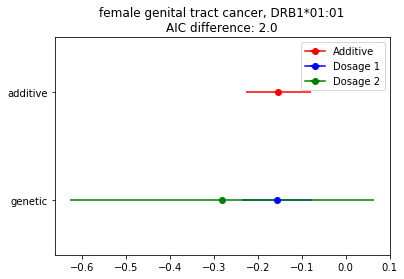

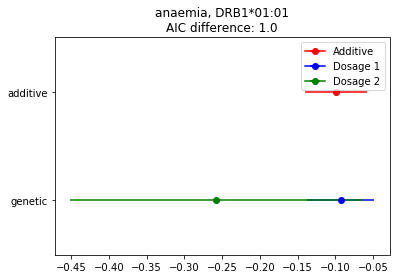

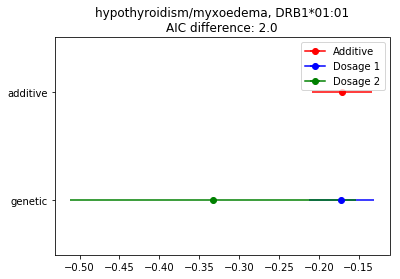

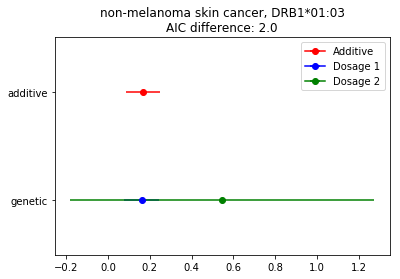

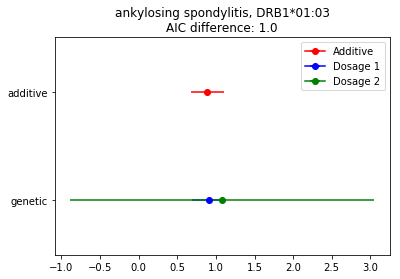

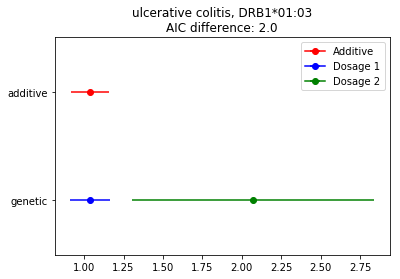

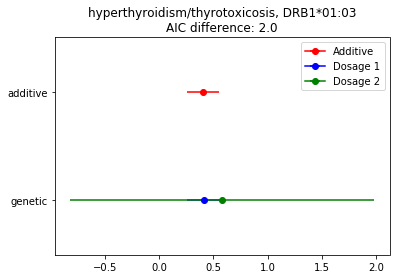

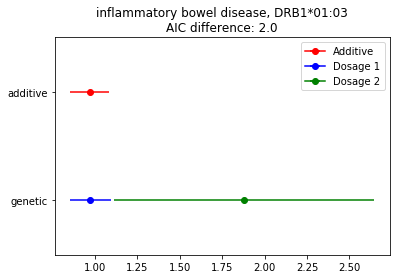

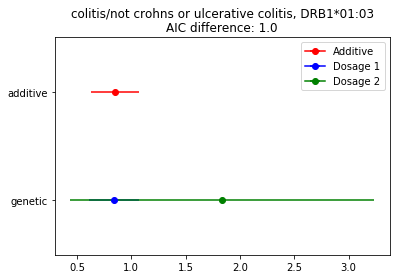

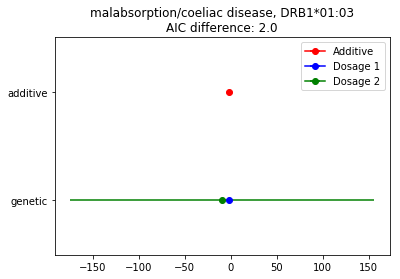

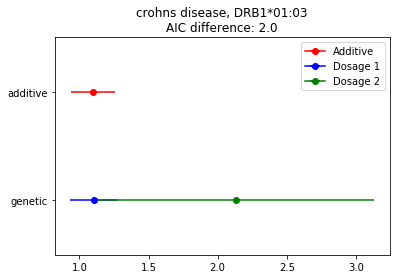

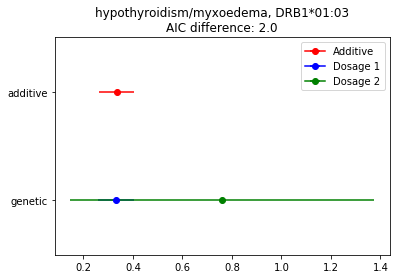

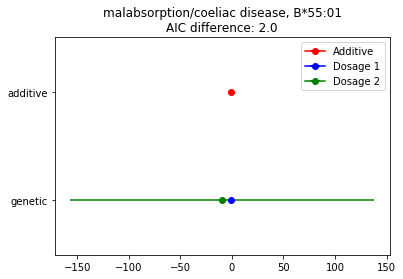

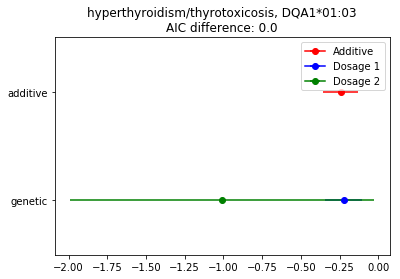

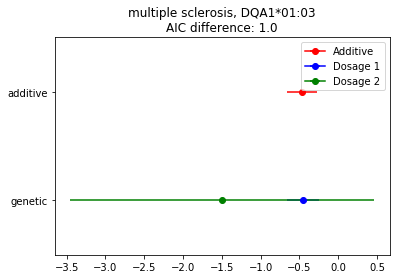

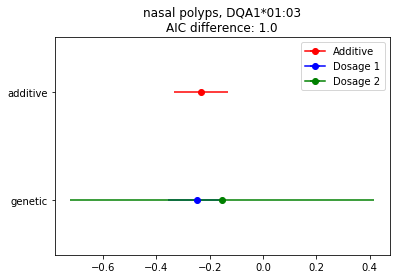

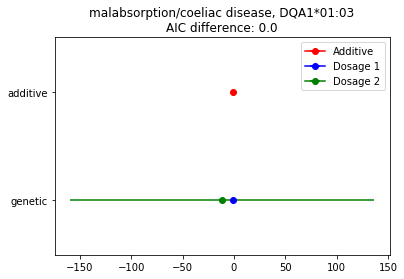

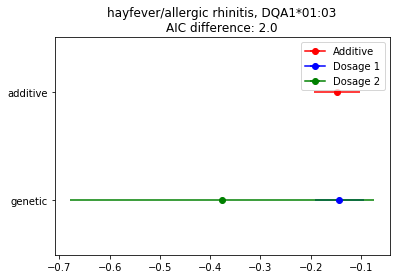

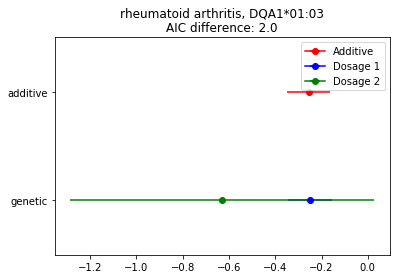

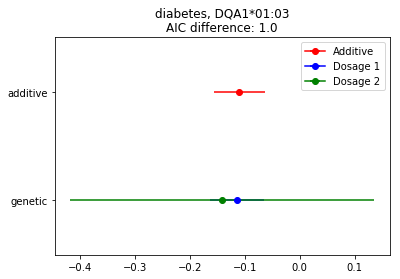

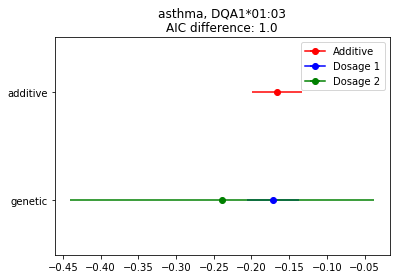

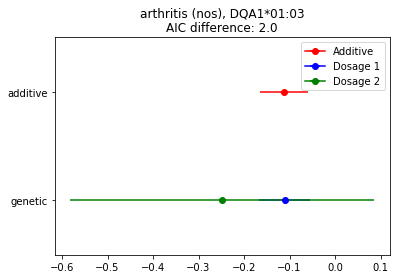

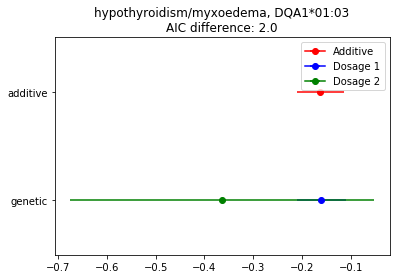

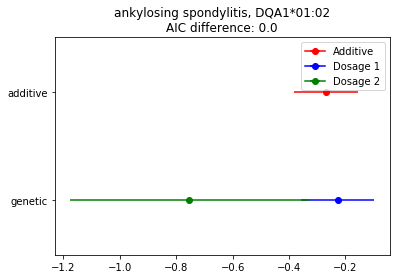

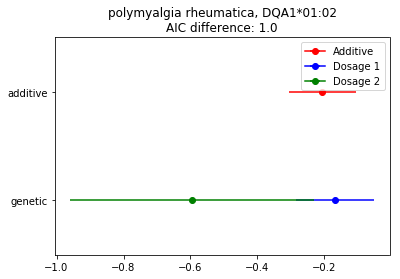

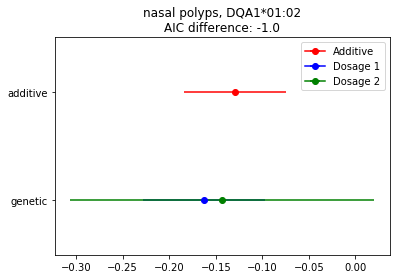

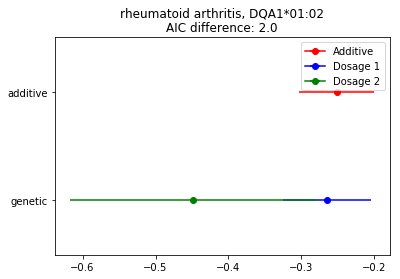

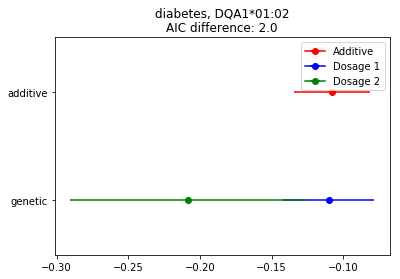

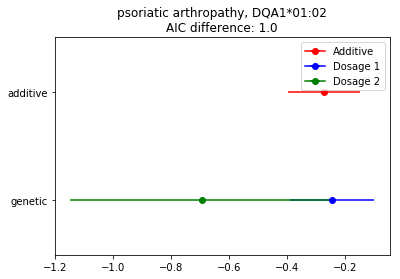

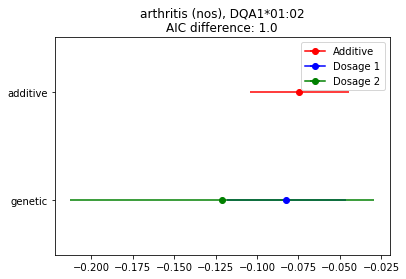

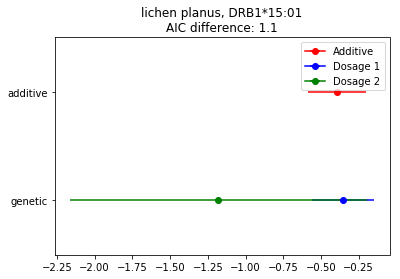

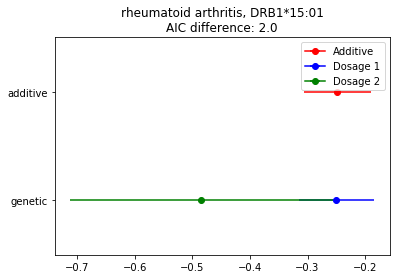

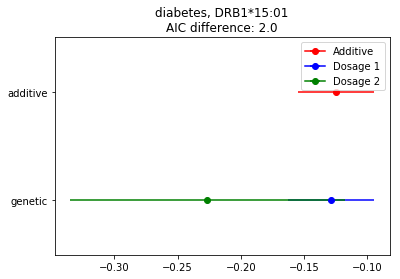

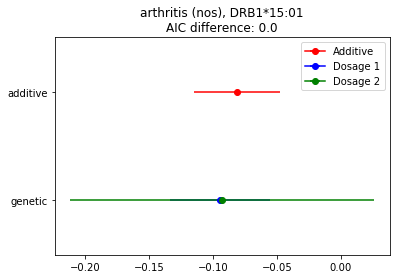

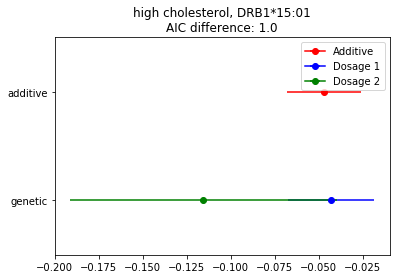

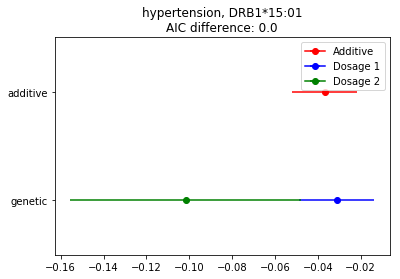

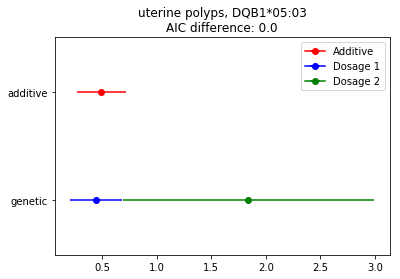

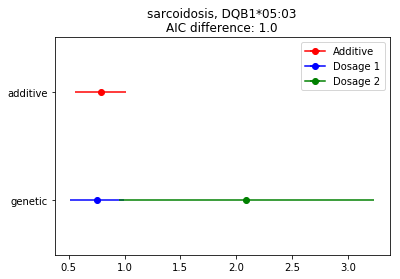

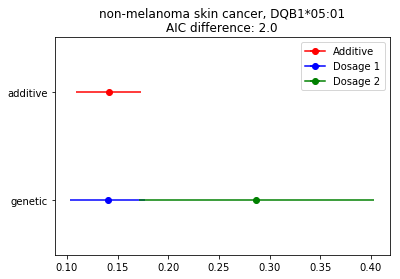

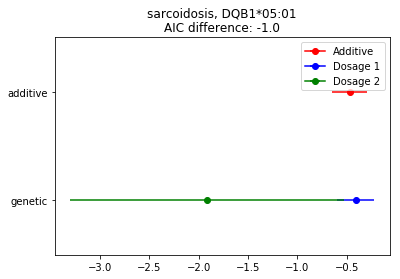

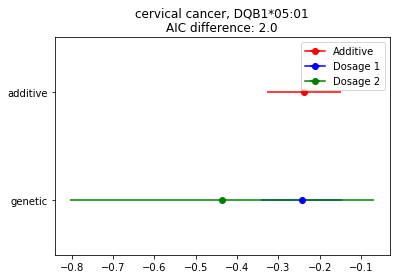

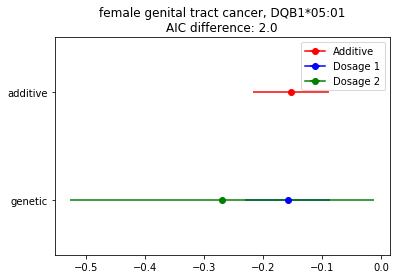

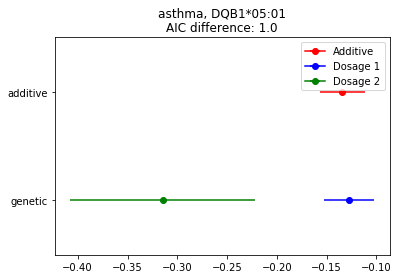

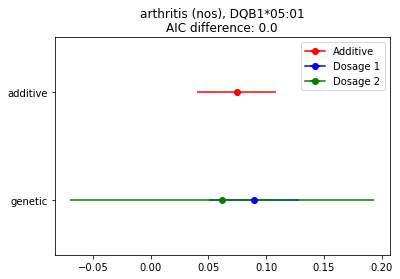

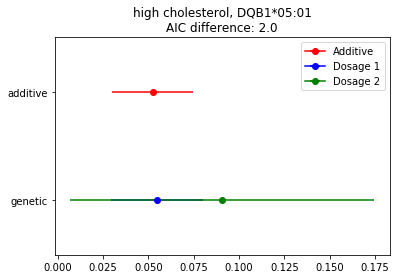

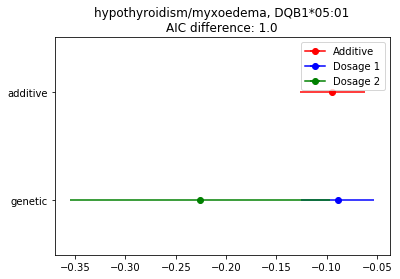

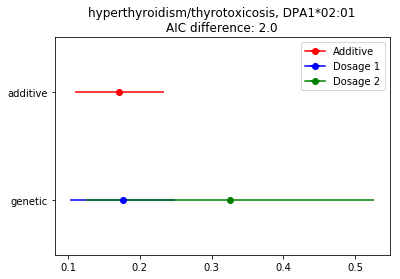

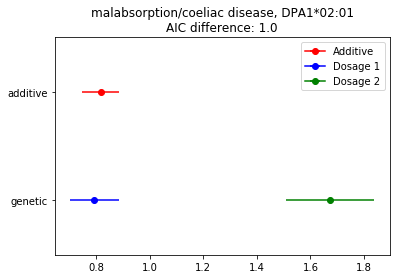

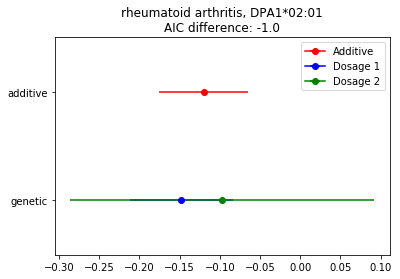

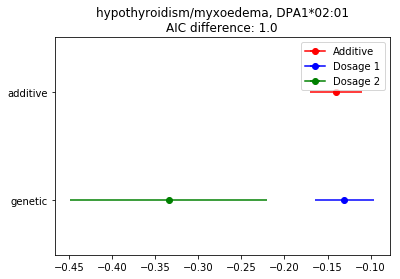

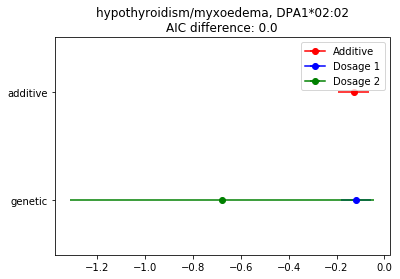

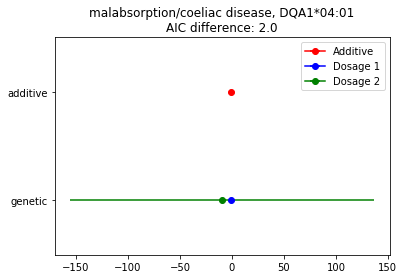

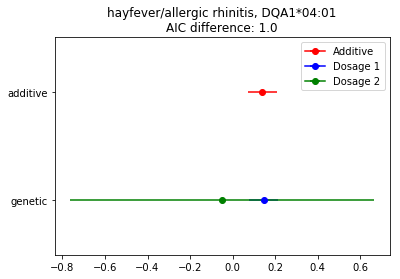

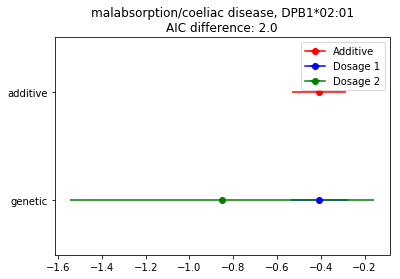

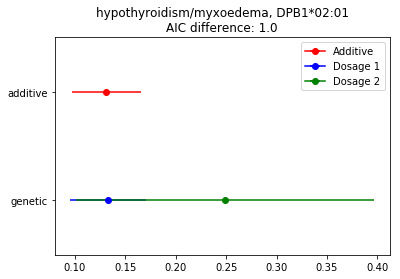

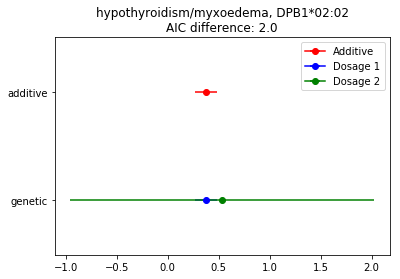

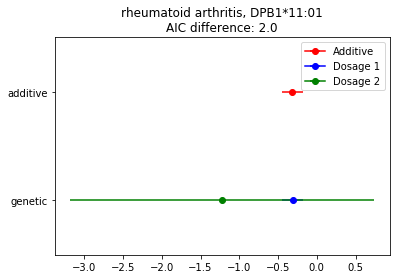

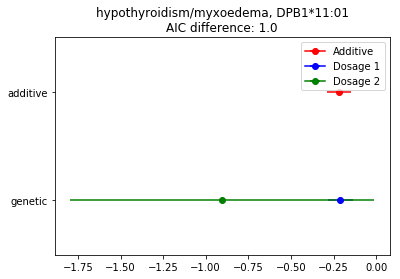

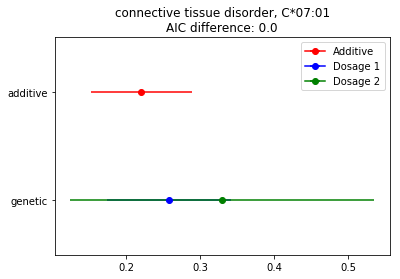

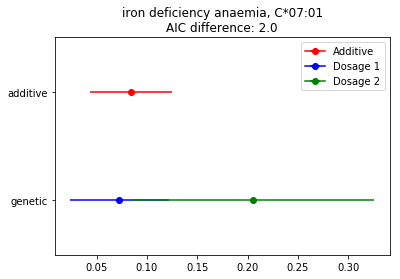

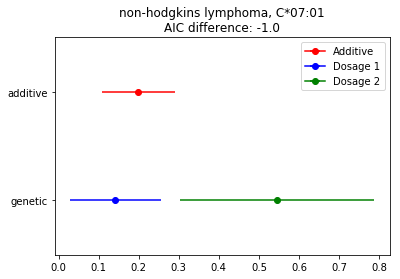

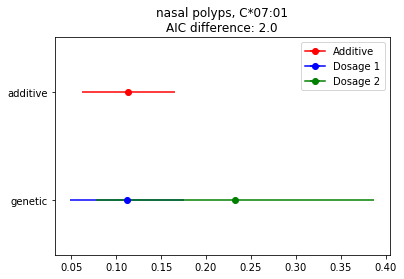

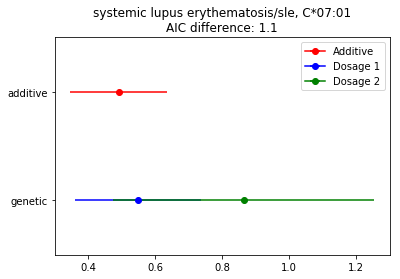

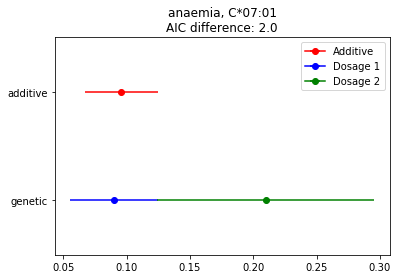

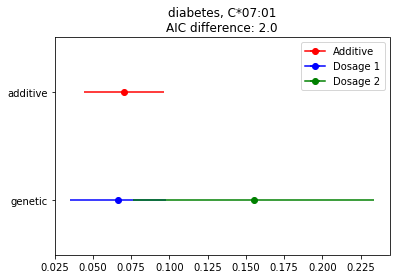

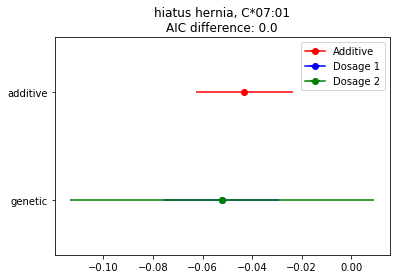

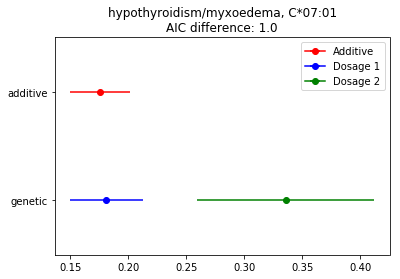

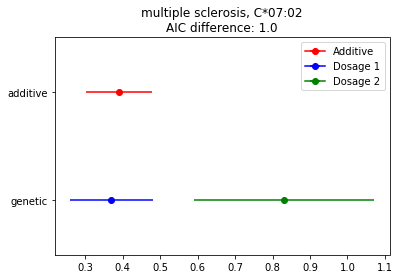

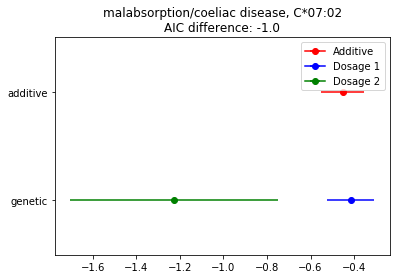

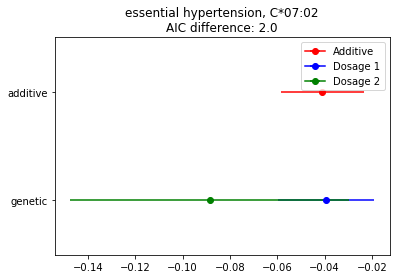

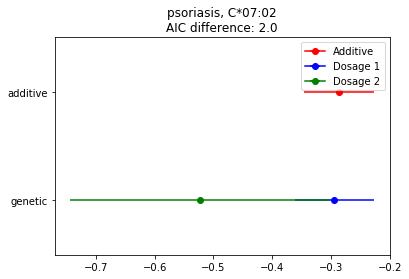

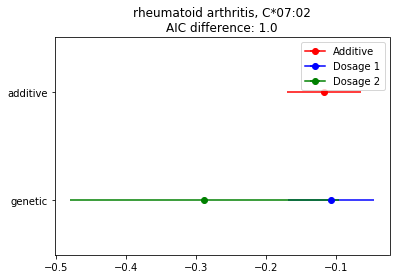

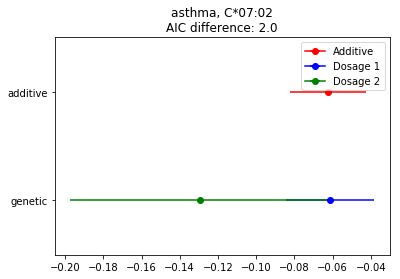

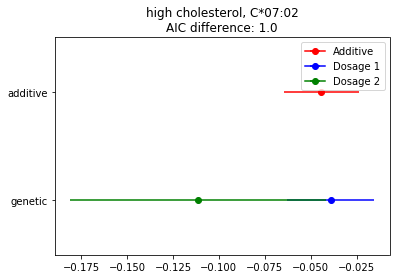

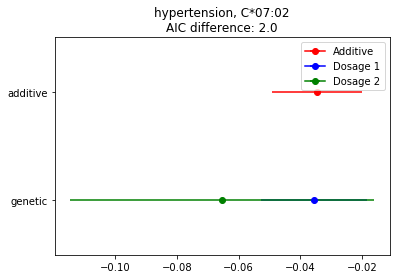

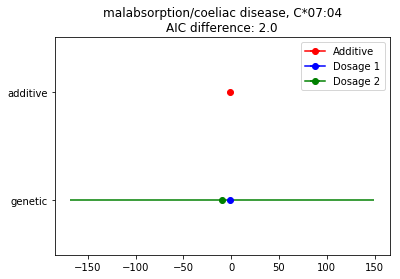

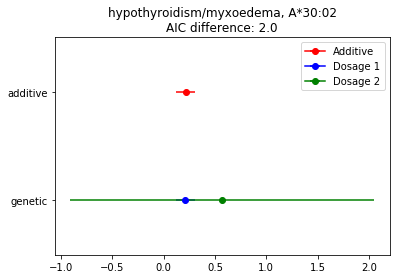

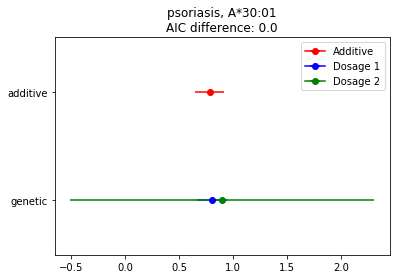

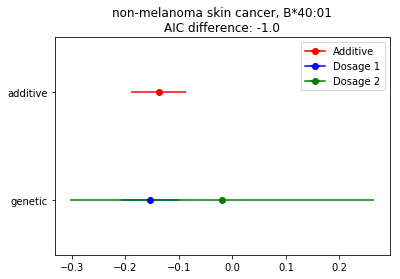

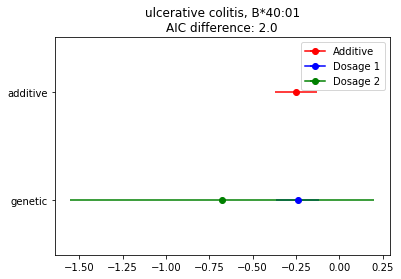

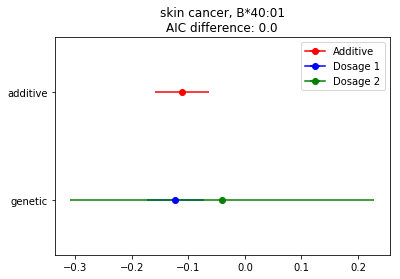

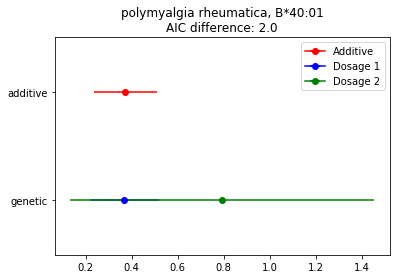

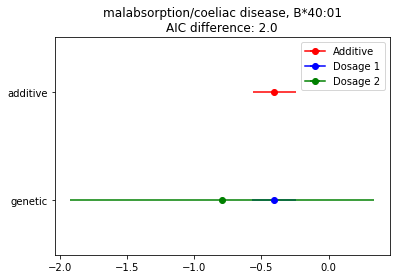

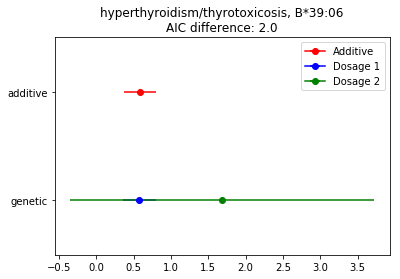

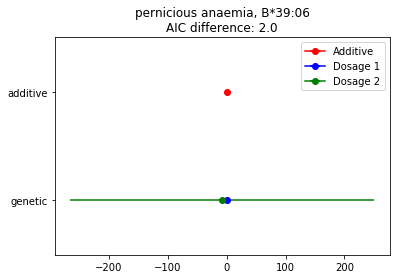

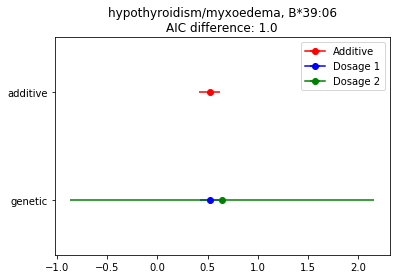

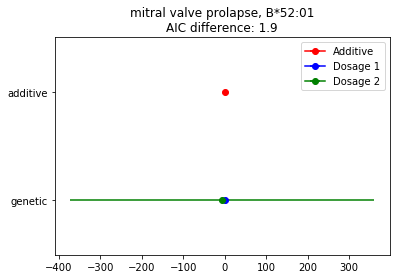

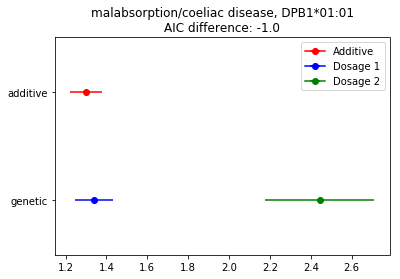

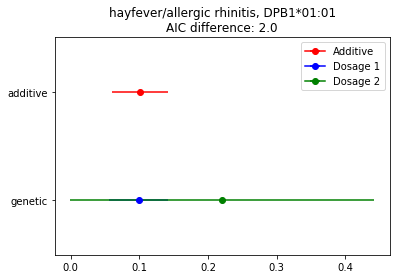

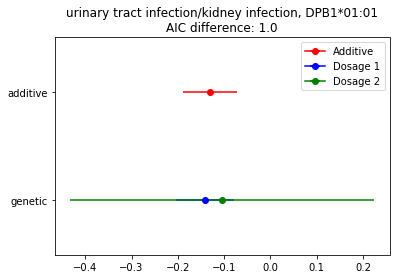

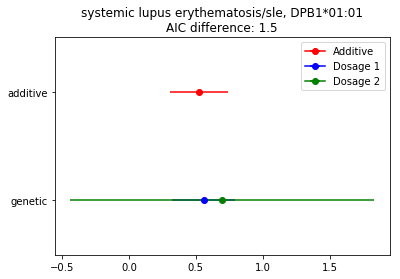

In [186]:
save_path = outpath + "compare_OR_plot/above_thresh/"
for allele in sub_df_2.columns.values:
    for phe in sub_df_2.index.values:
        if sub_df_2[allele][phe] >= AIC_thresh: 
            compare_OR_plot(phe,allele, gen_logOR_1, gen_logOR_2, gen_std_1, gen_std_2, add_logOR, add_std, sub_df_2, save_path)